# Forestry ARR Eligibility - GEE AND STAC Approach

This notebook demonstrates the STAC-based approach for forestry ARR eligibility analysis when historical Sentinel data is not available from Google Earth Engine.

## 📦 Required Libraries Installation

Before running this notebook, install the required libraries:

```bash
# Core STAC and GEE-xarray integration (REQUIRED)
pip install xarray>=2023.1.0 rioxarray>=0.15.0 xee>=0.0.8

# STAC client libraries
pip install planetary-computer>=0.4.0 pystac-client>=0.7.0 stackstac>=0.4.0

# Optional but recommended for better performance
pip install dask>=2023.1.0
```

Or install all at once:
```bash
pip install xarray rioxarray xee planetary-computer pystac-client stackstac dask
```

**Note:** `xarray` and `xee` are **required dependencies** - they enable Google Earth Engine integration with xarray for time series processing.

In [2]:
# Install required libraries for STAC processing
# Uncomment the line below if libraries are not installed
# !pip install xarray rioxarray xee planetary-computer pystac-client stackstac dask

# Verify installation - xarray and xee are REQUIRED
required_libs = {
    'xarray': 'xarray',  # REQUIRED - core dependency
    'rioxarray': 'rioxarray',  # REQUIRED - for geospatial raster operations
    'xee': 'xee',  # REQUIRED - Google Earth Engine to xarray bridge
    'planetary_computer': 'planetary-computer',  # For STAC access
    'pystac_client': 'pystac-client',  # For STAC client
    'stackstac': 'stackstac',  # For stacking STAC items
    'geopandas': 'geopandas',  # Core geospatial library
    'geemap': 'geemap'  # Optional - for GEE visualization
}

critical_libs = ['xarray', 'rioxarray', 'xee']  # Must-have libraries
missing_libs = []
missing_critical = []

for module_name, package_name in required_libs.items():
    try:
        __import__(module_name)
        status = "⭐" if module_name in critical_libs else "✅"
        print(f"{status} {module_name} is installed")
    except ImportError:
        status = "🚨" if module_name in critical_libs else "❌"
        print(f"{status} {module_name} is MISSING - install with: pip install {package_name}")
        missing_libs.append(package_name)
        if module_name in critical_libs:
            missing_critical.append(package_name)

if missing_critical:
    print(f"\n🚨 CRITICAL: Missing required libraries! Install them with:")
    print(f"   pip install {' '.join(missing_critical)}")
    raise ImportError(f"Required libraries missing: {', '.join(missing_critical)}")
elif missing_libs:
    print(f"\n⚠️ Missing optional libraries. Install them with:")
    print(f"   pip install {' '.join(missing_libs)}")
else:
    print("\n✅ All required libraries are installed!")


⭐ xarray is installed
⭐ rioxarray is installed
⭐ xee is installed
✅ planetary_computer is installed
✅ pystac_client is installed
✅ stackstac is installed
✅ geopandas is installed
✅ geemap is installed

✅ All required libraries are installed!


In [1]:
# !pip install xarray rioxarray xee planetary-computer pystac-client stackstac dask

In [3]:
import ee, eemont
from forestry_carbon_arr.core import ForestryCarbonARR

# Initialize Forestry Carbon ARR system
forestry = ForestryCarbonARR(config_path='./00_input/balaban_conf.json')
from_gee_version_1_config = forestry.config

In [4]:
from_gee_version_1_config

{'project': {'name': 'forestry_carbon_project',
  'region': 'global',
  'description': 'Forestry Carbon ARR Analysis Project',
  'version': '1.0.0'},
 'gee': {'project_id': None,
  'service_account': None,
  'initialize': True,
  'max_pixels': 10000000000000.0,
  'scale': 30,
  'crs': 'EPSG:4326'},
 'satellite': {'provider': 'Sentinel',
  'date_range': ['2024-01-01', '2024-12-31'],
  'cloud_cover_threshold': 40,
  'bands': {'Sentinel': ['B2', 'B3', 'B4', 'B8', 'B11', 'B12'],
   'Planet': ['red', 'green', 'blue', 'nir'],
   'Landsat': ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']},
  'composite_method': 'median',
  'mask_clouds': True},
 'ml': {'algorithm': 'gbm',
  'training_samples': 1000,
  'validation_split': 0.2,
  'cross_validation': True,
  'n_folds': 5,
  'random_state': 42,
  'hyperparameter_tuning': True},
 'fcd': {'method': 'pca',
  'thresholds': {'high_forest': 65,
   'yrf_forest': 55,
   'shrub_grass': 35,
   'open_land': 30},
  'apply_smoothing': True,
  'smoothing_kernel': 3},
 'c

In [5]:
### START TO WORK WITH STAC, check availability of historical sentinel data
import json
import geopandas as gpd
config = from_gee_version_1_config

#INPUT VARIABLES
is_export_image_to_drive = False

aoi_gpd = gpd.GeoDataFrame.from_file(config["AOI_path"])
aoi_gpd = aoi_gpd.to_crs(epsg=int(config['gee']["crs"].split(":")[-1])) # satellite crs is epsg code of projected UTM crs
if aoi_gpd.crs.to_string() == 'EPSG:4326':
    aoi_gpd = aoi_gpd.to_crs(epsg=3857)

aoi_ha = aoi_gpd.geometry.area.sum()/10000
print('area: (Ha) ', aoi_ha)

area: (Ha)  3411.880827453312


In [6]:
from forestry_carbon_arr.core.utils import DataUtils

d = DataUtils(config)
aoi_gpd, aoi_ee = d.load_geodataframe_gee(config["AOI_path"])

# we shall use the STAC approach if historical data of sentinel is not available from GEE 
# first we need to check in the AOI, date range availability, and do the historical data similar to the Hansen approach

# We should change the use_gee = True as use_hansen_gee = True vs use_tsfresh = True
# use_hansen_gee = True, is the first version of eligibility check that use landcover, and hansen tree cover
# use_tsfresh = True, is the second version of eligibility check that use tsfresh to extract the features from the time series of satellite data (replacing hansen) and current model will at the moment use 
## trees vs non-trees classification in use_tsfresh

# check the date range availability of the sentinel data - GEE xee, let's leverage the GEE with xarray,
from gee_lib.osi.image_collection.main import ImageCollection

# Create configuration for GEE ImageCollection

year_end = int(config['date_start_end'][1].split('-')[0])
ten_years_prior = year_end -10

new_date_start_end = [f'{ten_years_prior}-01-01', f"{config['date_start_end'][1]}"]

gee_config = {
    'AOI': aoi_ee,
    'date_start_end': new_date_start_end,
    'cloud_cover_threshold': config['cloud_cover_threshold'],
    'config': {'IsThermal': False}
}

# Initialize ImageCollection
image_collection = ImageCollection(
    I_satellite=config['I_satellite'],
    region=aoi_gpd,
    **gee_config
)

# Get the raw ImageCollection (not mosaicked)
raw_collection = image_collection.image_collection_mask()
## masking cloud, get xarray with applied cloud mask

✓ GEE Initialized successfully
  Credentials Path: /usr/src/app/user_id.json - loaded successfully
selecting Sentinel images


## Step 2: Convert to UTM CRS (meters)

**Why UTM?**
- UTM uses meters as units (not degrees like EPSG:4326)
- Scale parameter in xee should match CRS units
- Sentinel-2: 10m pixels means 10 meters, which only makes sense in UTM
- Better for spatial analysis and area calculations

**Steps:**
1. Determine UTM zone from AOI centroid longitude
2. Reproject raw_collection in Earth Engine to UTM
3. Update xee parameters to use UTM CRS and meter scale


In [7]:
# Step 1: Determine UTM zone from AOI centroid
# UTM zones are calculated based on longitude: zone = floor((lon + 180) / 6) + 1

import numpy as np

# Get centroid longitude (must be in WGS84/ EPSG:4326 for UTM calculation)
if aoi_gpd.crs.to_string() != 'EPSG:4326':
    aoi_wgs84 = aoi_gpd.to_crs('EPSG:4326')
else:
    aoi_wgs84 = aoi_gpd

centroid_lon = aoi_wgs84.geometry.centroid.x.mean()
centroid_lat = aoi_wgs84.geometry.centroid.y.mean()

# Calculate UTM zone
utm_zone = int(np.floor((centroid_lon + 180) / 6)) + 1

# Determine hemisphere (N or S) based on latitude
hemisphere = 'N' if centroid_lat >= 0 else 'S'

# UTM EPSG code format: EPSG:326XX (northern) or EPSG:327XX (southern)
if hemisphere == 'N':
    utm_epsg = 32600 + utm_zone  # Northern hemisphere
else:
    utm_epsg = 32700 + utm_zone  # Southern hemisphere

print(f"📍 AOI Centroid: ({centroid_lat:.4f}°, {centroid_lon:.4f}°)")
print(f"🗺️  UTM Zone: {utm_zone}{hemisphere}")
print(f"🔢 UTM EPSG Code: EPSG:{utm_epsg}")
print(f"📐 CRS Units: Meters (✅ matches scale units)")

# Update config with UTM CRS
config['utm_crs'] = f'EPSG:{utm_epsg}'
config['utm_zone'] = utm_zone
config['utm_hemisphere'] = hemisphere


📍 AOI Centroid: (-1.8038°, 110.4631°)
🗺️  UTM Zone: 49S
🔢 UTM EPSG Code: EPSG:32749
📐 CRS Units: Meters (✅ matches scale units)


/tmp/ipykernel_27/3455030237.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid_lon = aoi_wgs84.geometry.centroid.x.mean()
/tmp/ipykernel_27/3455030237.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid_lat = aoi_wgs84.geometry.centroid.y.mean()


In [8]:
# Step 2: Reproject raw_collection to UTM in Earth Engine
# This ensures the ImageCollection is in meters before xee conversion

print("🔄 Reprojecting raw_collection to UTM...")

# Reproject each image in the collection to UTM
# scale: pixel size in meters (10m for Sentinel-2)
# crs: UTM EPSG code

if config['I_satellite'] == 'Sentinel':
    pixel_scale = 10  # meters for Sentinel-2
elif config['I_satellite'] == 'Landsat':
    pixel_scale = 30  # meters for Landsat
else:
    pixel_scale = 10  # default

# Reproject the collection
raw_collection_utm = raw_collection.map(
    lambda image: image.reproject(
        crs=f'EPSG:{utm_epsg}',
        scale=pixel_scale
    )
)

print(f"✅ Reprojected to {config['utm_crs']}")
print(f"   Scale: {pixel_scale}m (matches CRS units)")

# Update the collection variable
raw_collection = raw_collection_utm


🔄 Reprojecting raw_collection to UTM...
✅ Reprojected to EPSG:32749
   Scale: 10m (matches CRS units)


## Data preparation for DS XEE

In [9]:
# Step 1: Import xee library
import ee
import numpy as np

# Step 2: Check the raw_collection structure
print("📊 Raw Collection Info:")
print(f"Type: {type(raw_collection)}")
print(f"Is ImageCollection: {isinstance(raw_collection, ee.ImageCollection)}")

# Step 3: Get the AOI bounding box in UTM (required for xee)
# First, transform aoi_ee geometry to UTM so bounds are in meters
print(f"\n🔄 Converting AOI geometry to UTM ({config['utm_crs']})...")
aoi_gpd_utm = aoi_gpd.to_crs(f'EPSG:{utm_epsg}')
aoi_gpd_utm.set_crs(f'EPSG:{utm_epsg}', inplace=True)

# aoi_ee_utm_geom = geemap.geopandas_to_ee(aoi_gpd_utm) # not possible, uploaded fc will automatically 4326

# # Get bounds from UTM geometry (now in meters)
# aoi_bounds_utm = aoi_ee_utm_geom.bounds().getInfo()
# print(f"📍 AOI Bounds (UTM): {aoi_bounds_utm}")

# # Extract the coordinates from UTM bounds
# coordinates_utm = aoi_bounds_utm['coordinates'][0]
# # xee expects region as a list: [west, south, east, north] or a GeoJSON-like dict
# # Bounds are now in meters (UTM)
# from shapely.geometry import box
# bounds_list_utm = [coordinates_utm[0][0], coordinates_utm[0][1], coordinates_utm[2][0], coordinates_utm[2][1]]
# print(f"Bounds list format [west, south, east, north] in meters: {bounds_list_utm}")
# print(f"   Note: These coordinates are in UTM meters, not degrees!")

# Also keep the UTM geometry for later use
# aoi_ee_utm = aoi_ee_utm_geom  # Save for use in xee conversion


📊 Raw Collection Info:
Type: <class 'ee.imagecollection.ImageCollection'>
Is ImageCollection: True

🔄 Converting AOI geometry to UTM (EPSG:32749)...


,FID_1,kode_prov,kode_kab,hd_id,nama_kec,nama_desa,nama_ld,no_sk_pphd,tgl_sk_pph,no_sk_pak_,...,st_length_,A1NAME,A1CODE,A2CODE,A2NAME,TYPE,A2TEXT,Hectares,id,geometry
0,554.0,61.0,6104.0,610418.0,Sungai Melayu Rayak,Sungai Melayu,LPHD Belaban Rayak,SK.4670/MENLHK-PSKL/PKPS/PSL.0/7/2018,2018/07/06 08:00:00.000,-,...,0.229771,KALIMANTAN BARAT,61.0,6106.0,KETAPANG,Kabupaten,6106,3385.72723,0,"POLYGON ((443293.000 9803079.000, 443402.418 9..."


In [10]:
# aoi_gpd_utm

In [11]:
# aoi_gpd_utm.geometry

In [12]:
# Step 4: Configure xee parameters for UTM
# Now we use UTM CRS (meters) which matches the scale units

# Scale is already set from previous step (10m for Sentinel-2)
print(f"📐 Pixel Scale: {pixel_scale}m ({config['I_satellite']})")

# Use UTM CRS (already calculated)
utm_crs = config['utm_crs']
print(f"🌍 CRS: {utm_crs} (UTM Zone {config['utm_zone']}{config['utm_hemisphere']})")
print(f"✅ Scale and CRS units both in meters - correct!")

# Extract EPSG code for xee
epsg_code = utm_epsg


📐 Pixel Scale: 10m (Sentinel)
🌍 CRS: EPSG:32749 (UTM Zone 49S)
✅ Scale and CRS units both in meters - correct!


<Axes: >

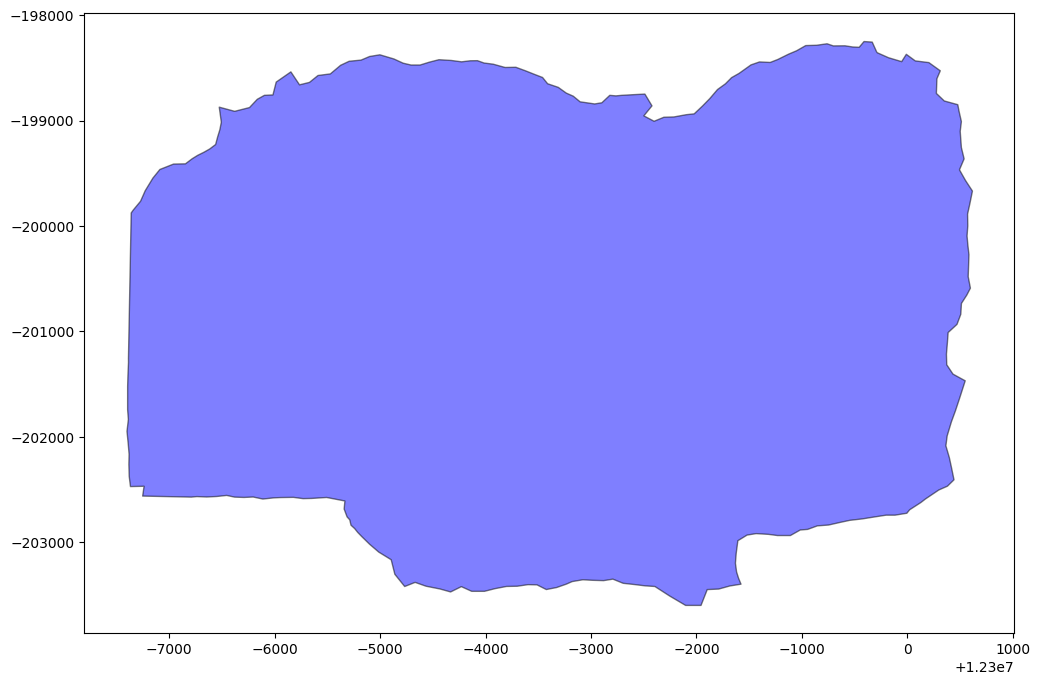

In [13]:
type(aoi_gpd)
# Simple way to plot geometry - just call .plot() method
aoi_gpd.plot(figsize=(12, 12), color='blue', edgecolor='black', alpha=0.5)

# Or use the geometry directly
# geom = aoi_gpd.geometry
# geom.plot(figsize=(10, 10), color='green', edgecolor='red', linewidth=2)


In [14]:
# display(geom)

In [15]:
pixel_scale

10

In [16]:
# raw_collection

In [17]:
# Add Spectral Indices to ImageCollection
# Map spectral indices over each image in the collection using SpectralAnalysis

from gee_lib.osi.spectral_indices.spectral_analysis import SpectralAnalysis

print("🔄 Adding spectral indices to ImageCollection...")
print(f"   Satellite: {config['I_satellite']}")
print("   Mapping indices over each image in collection...")

# Prepare config for SpectralAnalysis
spectral_config = {
    'I_satellite': config['I_satellite'],
    'AOI': aoi_ee.geometry(),  # Use the AOI geometry
    'pca_scaling': config.get('pca_scaling', 1),
    'tileScale': config.get('tileScale', 2)
}

# Define function to add spectral indices to a single image
def add_spectral_indices(image):
    """
    Add spectral indices to a single image using SpectralAnalysis.
    
    Available indices based on satellite type:
    - All: NDVI, NDWI, MSAVI2, MTVI2, VARI
    - Sentinel/Landsat: BSI (requires swir1)
    Note: AVI and SI require max_bands per image (expensive), typically calculated on mosaics
    """
    # Create SpectralAnalysis instance for this image
    spectral = SpectralAnalysis(image, spectral_config)
    
    # Start with original image
    image_with_indices = image
    
    # Add simple indices (no max_bands calculation needed)
    ndvi = spectral.NDVI_func()
    ndwi = spectral.NDWI_func()
    msavi2 = spectral.MSAVI2_func()
    mtvi2 = spectral.MTVI2_func()
    vari = spectral.VARI_func()
    
    image_with_indices = image_with_indices.addBands([ndvi, ndwi, msavi2, mtvi2, vari])
    
    # Add BSI for Sentinel/Landsat (requires swir1)
    if config['I_satellite'] in ['Sentinel', 'Landsat']:
        try:
            bsi = spectral.BSI_func()
            image_with_indices = image_with_indices.addBands(bsi)
        except:
            # BSI requires swir1 - skip if not available
            pass
    
    return image_with_indices

# Map the function over the ImageCollection
collection_with_indices = raw_collection.map(add_spectral_indices)

print("✅ Spectral indices added to ImageCollection!")
print("   Added: NDVI, NDWI, MSAVI2, MTVI2, VARI")
if config['I_satellite'] in ['Sentinel', 'Landsat']:
    print("   (BSI added if swir1 band available)")

# Get info about bands in first image
first_image = ee.Image(collection_with_indices.first())
band_names = first_image.bandNames().getInfo()
print(f"\n📊 First image now has {len(band_names)} bands:")
print(f"   Bands: {', '.join(band_names[:15])}{'...' if len(band_names) > 15 else ''}")

🔄 Adding spectral indices to ImageCollection...
   Satellite: Sentinel
   Mapping indices over each image in collection...
✅ Spectral indices added to ImageCollection!
   Added: NDVI, NDWI, MSAVI2, MTVI2, VARI
   (BSI added if swir1 band available)

📊 First image now has 17 bands:
   Bands: blue, green, red, redE1, redE2, redE3, nir, redE4, swir1, swir2, cloudM, NDVI, ndwi, msavi2, MTVI2...


In [18]:
# Add FCD-related indices to ImageCollection
# 
# Simplified Forest Canopy Density (FCD) Proxy Approach
# 
# This approach uses simplified vegetation density indicators as proxies for FCD
# when full PCA-based FCD calculation is computationally prohibitive per image.
# 
# Source Literature for Simplified Approach:
# 1. Tucker, C. J. (1979). Red and photographic infrared linear combinations for monitoring vegetation. 
#    Remote Sensing of Environment, 8(2), 127-150.
#    https://doi.org/10.1016/0034-4257(79)90013-0
#    (NDVI foundation and vegetation monitoring)
#
# 2. Gao, B. C. (1996). NDWI—A normalized difference water index for remote sensing of vegetation 
#    liquid water from space. Remote Sensing of Environment, 58(3), 257-266.
#    https://doi.org/10.1016/S0034-4257(96)00067-3
#    (NDWI for water/vegetation discrimination)
#
# 3. Huete, A., Didan, K., Miura, T., Rodriguez, E. P., Gao, X., & Ferreira, L. G. (2002). 
#    Overview of the radiometric and biophysical performance of the MODIS vegetation indices. 
#    Remote Sensing of Environment, 83(1-2), 195-213.
#    https://doi.org/10.1016/S0034-4257(02)00096-2
#    (Enhanced vegetation indices and density proxies)
#
# 4. Gitelson, A. A., Kaufman, Y. J., & Merzlyak, M. N. (1996). Use of a green channel in remote 
#    sensing of global vegetation from EOS-MODIS. Remote Sensing of Environment, 58(3), 289-298.
#    https://doi.org/10.1016/S0034-4257(96)00072-7
#    (Vegetation density enhancement techniques)
#
# IMPROVED APPROACH: Pseudo Forest Canopy Density (Pseudo-FCD)
# Based on: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/pseudo_forest_canopy_density/
# Author: Antonio Carlon Paredes (2019)
# License: CC BY 4.0
# Reference: Azadeh ABDOLLAHNEJAD et al. "Forest canopy density assessment using different approaches"
#            Journal of Forest Science, 63, 2017 (3): 106-115
#
# This approach uses simplified versions of FCD indices without PCA:
# - NDVI (Normalized Difference Vegetation Index)
# - BI (Bare soil index) = (NIR + Green + Red) / (NIR + Green - Red)
# - SI (Shadow index) = ((1 - Green) * (1 - Red))^0.5
# - NDWI (Normalized Difference Water Index) for water detection
#
# Classification thresholds (adjustable per location):
# - High Forest: NDVI > 0.40, BI < 2, SI > 0.93
# - Low Forest: 0.20 < NDVI < 0.40, BI < 2, 0.90 < SI < 0.93
# - Grassland: NDVI > 0.20
# - Bare land: NDVI < 0.20, BI > 2, SI < 0.90
# - Water: NDWI > 0.2
#
# ============================================================================
# WHY FCD IS COMPUTATIONALLY EXPENSIVE FOR IMAGECOLLECTION MAPPING:
# ============================================================================
# 1. PCA (Principal Component Analysis) Requirements:
#    - Requires reduceRegion operations over entire AOI to compute:
#      * Mean values (mean centering)
#      * Covariance matrix (centeredCovariance reducer)
#      * Eigenvalue/eigenvector decomposition
#    - These operations scan ALL pixels in AOI per image
#    - When mapping over ImageCollection: O(n_images × AOI_pixels)
#
# 2. max_bands() Calculation (for AVI and SI):
#    - Each index (AVI, SI) requires reduceRegion(max) per band
#    - For AVI: max(red), max(green), max(blue) - 3 reduceRegion calls
#    - For SI: same 3 reduceRegion calls
#    - Per image: 6 expensive reduceRegion operations
#
# 3. normalization_100() Function:
#    - Requires reduceRegion to compute mean and stdDev
#    - Called for each band/index that needs normalization
#    - Per image: Multiple reduceRegion operations
#
# Total cost per image:
# - 1-2 PCA operations (SVI, SSI)
# - 6 reduceRegion for max_bands()
# - Multiple reduceRegion for normalization
# =~ 10+ reduceRegion operations × AOI pixel count
# ============================================================================
#
# ALTERNATIVE APPROACHES (besides current simplification):
# ============================================================================
# 1. PRE-COMPUTED STATISTICS APPROACH:
#    - Compute PCA/eigenvalues once from a representative mosaic
#    - Compute max_bands once from mosaic
#    - Apply same transformation to all images in collection
#    - Trade-off: Less accurate but 10-100x faster
#
# 2. REGIONAL NORMALIZATION APPROACH:
#    - Compute normalization parameters (mean, std) once from sample
#    - Apply fixed normalization to all images
#    - More consistent but less adaptive per-image
#
# 3. SIMPLIFIED FCD WITHOUT PCA:
#    - Use direct band combinations (e.g., NDVI * SI instead of PCA)
#    - Skip eigenvector decomposition
#    - Trade-off: Less mathematically rigorous but much faster
#
# 4. CHUNK-BASED PROCESSING:
#    - Process collection in batches
#    - Compute statistics per batch instead of per image
#    - Intermediate accuracy between per-image and global
#
# 5. APPROXIMATE PCA:
#    - Use sample-based covariance (reduceRegion on sample points)
#    - Use approximate eigen decomposition
#    - Faster but slightly less accurate
#
# Note: Full FCD calculation requires PCA which is computationally expensive per image
# This adds simplified FCD-related indices that can be calculated per image

from gee_lib.osi.spectral_indices.spectral_analysis import SpectralAnalysis
from gee_lib.osi.spectral_indices.utils import normalization_100

print("🔄 Adding FCD-related indices to ImageCollection...")
print(f"   Satellite: {config['I_satellite']}")
print("   Note: Full FCD requires PCA (expensive per image), adding simplified indices...")

# Prepare config for SpectralAnalysis
fcd_config = {
    'I_satellite': config['I_satellite'],
    'AOI': aoi_ee.geometry(),
    'pca_scaling': config.get('pca_scaling', 1),
    'tileScale': config.get('tileScale', 2)
}

def add_fcd_indices(image):
    """
    Add Pseudo Forest Canopy Density (Pseudo-FCD) indices to a single image.
    
    Based on: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/pseudo_forest_canopy_density/
    Uses simplified FCD indices without PCA for computational efficiency.
    Note: NDVI and NDWI are already added in spectral indices step, so we reuse them.
    """
    # Start with image that already has spectral indices
    image_with_fcd = image
    
    try:
        # Use existing NDVI and NDWI from spectral indices (don't recalculate)
        ndvi = image.select('NDVI')
        ndwi = image.select('ndwi')
        
        # BI (Bare soil index) - simplified version
        # BI = (NIR + Green + Red) / (NIR + Green - Red)
        bi = image.expression(
            '(NIR + Green + Red) / (NIR + Green - Red)', {
                'NIR': image.select('nir'),
                'Green': image.select('green'),
                'Red': image.select('red')
            }
        ).rename('BI')
        
        # SI (Shadow index) - simplified version
        # SI = ((1 - Green) * (1 - Red))^0.5
        si = image.expression(
            'pow((1 - Green) * (1 - Red), 0.5)', {
                'Green': image.select('green'),
                'Red': image.select('red')
            }
        ).rename('SI')
        
        # Add BI and SI to image
        image_with_fcd = image_with_fcd.addBands([bi, si])
        
        # Calculate continuous Pseudo-FCD percentage (0-100%)
        # Normalize proxies to [0,1] with practical ranges (tunable)
        ndvi_s = ndvi.unitScale(0.20, 0.80).clamp(0, 1)        # vegetation density
        si_s   = si.unitScale(0.90, 0.98).clamp(0, 1)          # canopy/shadow strength
        # BI high => more bare soil; invert and normalize (tune 1..3 as needed)
        bi_inv = ee.Image(1).subtract(bi.unitScale(1.0, 3.0)).clamp(0, 1)
        
        # Weighted combination (tune weights to your site)
        pseudo_fcd_0_1 = (
            ndvi_s.multiply(0.5)
            .add(si_s.multiply(0.3))
            .add(bi_inv.multiply(0.2))
        ).clamp(0, 1)
        
        # Optional: suppress water influence
        water_mask = ndwi.lte(0.2)  # NDWI > 0.2 => water
        pseudo_fcd_0_1 = pseudo_fcd_0_1.updateMask(water_mask)
        
        # Scale to 0–100% and add as band
        pseudo_fcd_pct = pseudo_fcd_0_1.multiply(100).rename('pseudo_fcd_pct')
        image_with_fcd = image_with_fcd.addBands(pseudo_fcd_pct)
        
    except Exception as e:
        print(f"Warning: Could not add Pseudo-FCD indices: {e}")
    
    return image_with_fcd

# Map the function over the collection with spectral indices
collection_with_fcd = collection_with_indices.map(add_fcd_indices)

print("✅ Pseudo-FCD indices added to ImageCollection!")
print("   Added: BI (Bare soil index), SI (Shadow index), pseudo_fcd_pct (0-100%)")
print("   Reused: NDVI, NDWI from spectral indices step")
print("   Based on: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/pseudo_forest_canopy_density/")
print("   No PCA required - computationally efficient for ImageCollection mapping")

# Get info about bands in first image
first_image = ee.Image(collection_with_fcd.first())
band_names = first_image.bandNames().getInfo()
print(f"\n📊 First image now has {len(band_names)} bands:")
print(f"   Bands: {', '.join(band_names[:20])}{'...' if len(band_names) > 20 else ''}")

# Show which FCD-related bands were added
fcd_bands = [b for b in band_names if any(x in b.lower() for x in ['bsi', 'si', 'veg_density', 'forest_proxy'])]
if fcd_bands:
    print(f"\n🌲 FCD-related bands: {', '.join(fcd_bands)}")
else:
    print("\n⚠️ No FCD-related bands found (may have failed to calculate)")


🔄 Adding FCD-related indices to ImageCollection...
   Satellite: Sentinel
   Note: Full FCD requires PCA (expensive per image), adding simplified indices...
✅ Pseudo-FCD indices added to ImageCollection!
   Added: BI (Bare soil index), SI (Shadow index), pseudo_fcd_pct (0-100%)
   Reused: NDVI, NDWI from spectral indices step
   Based on: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/pseudo_forest_canopy_density/
   No PCA required - computationally efficient for ImageCollection mapping

📊 First image now has 20 bands:
   Bands: blue, green, red, redE1, redE2, redE3, nir, redE4, swir1, swir2, cloudM, NDVI, ndwi, msavi2, MTVI2, VARI, BSI, BI, SI, pseudo_fcd_pct

🌲 FCD-related bands: BSI, SI


In [19]:
### ADDING SPECTRAL INDICES WITH FCD PSEUDO-FCD
collection_with_fcd.first().bandNames().getInfo()

['blue',
 'green',
 'red',
 'redE1',
 'redE2',
 'redE3',
 'nir',
 'redE4',
 'swir1',
 'swir2',
 'cloudM',
 'NDVI',
 'ndwi',
 'msavi2',
 'MTVI2',
 'VARI',
 'BSI',
 'BI',
 'SI',
 'pseudo_fcd_pct']

In [20]:
# Dynamically get all available spectral indices from eemont-osi
# import sys
# sys.path.insert(0, '/usr/src/app/eemont-osi')
import ee_extra.Spectral.core as spec_core

# Get all available indices dynamically
indices_dict = spec_core.indices(online=False)
spectral_indices_awesome_list = sorted(list(indices_dict.keys()))

print(f"✅ Loaded {len(spectral_indices_awesome_list)} spectral indices from eemont-osi")
print(f"\nFirst 10 indices: {spectral_indices_awesome_list[:10]}")
print(f"\nLast 10 indices: {spectral_indices_awesome_list[-10:]}")
print(f"\n✅ List ready to use: spectral_indices_awesome_list")

# Function to get formula and metadata for any spectral index
def get_index_info(index_name):
    """
    Get formula and metadata for a spectral index.
    
    Parameters:
    -----------
    index_name : str
        Name of the spectral index (e.g., 'NDVI', 'EVI', 'SAVI')
    
    Returns:
    --------
    dict : Dictionary containing:
        - formula: Mathematical formula string
        - long_name: Full name of the index
        - bands: List of bands used (N=NIR, R=Red, G=Green, B=Blue, S1=SWIR1, S2=SWIR2, RE1-4=Red Edge)
        - application_domain: Category (vegetation, water, burn, etc.)
        - platforms: Supported satellite platforms
        - reference: Reference URL or DOI
    """
    index_name_upper = index_name.upper()
    
    if index_name_upper not in indices_dict:
        available = [idx for idx in spectral_indices_awesome_list if index_name.upper() in idx.upper()]
        raise ValueError(
            f"Index '{index_name}' not found. "
            f"Did you mean: {available[:5] if available else 'None'}?"
        )
    
    info = indices_dict[index_name_upper].copy()
    return info

def formula(index_name):
    """
    Get the formula for a spectral index.
    
    Parameters:
    -----------
    index_name : str
        Name of the spectral index (e.g., 'NDVI', 'EVI', 'SAVI')
    
    Returns:
    --------
    str : Mathematical formula string using band abbreviations
         Band abbreviations: N (NIR), R (Red), G (Green), B (Blue), 
         S1 (SWIR1), S2 (SWIR2), RE1-4 (Red Edge 1-4)
    
    Examples:
    --------
    >>> formula('NDVI')
    '(N - R)/(N + R)'
    
    >>> formula('EVI')
    'G * ((N - R) / (N + C1 * R - C2 * B + L))'
    """
    info = get_index_info(index_name)
    return info['formula']

# Function to convert formula band abbreviations to OSI band names
def formula_to_osi_bands(formula_str):
    """
    Convert eemont-osi formula band abbreviations to OSI band names.
    
    Mapping:
    - N (NIR) -> nir
    - R (Red) -> red
    - G (Green) -> green
    - B (Blue) -> blue
    - S1 (SWIR1) -> swir1
    - S2 (SWIR2) -> swir2
    - RE1 (Red Edge 1) -> redE1
    - RE2 (Red Edge 2) -> redE2
    - RE3 (Red Edge 3) -> redE3
    - RE4 (Red Edge 4) -> redE4
    - Variables (g, C1, C2, L, etc.) remain as-is
    
    Parameters:
    -----------
    formula_str : str
        Formula string from eemont-osi (e.g., "(N - R)/(N + R)")
    
    Returns:
    --------
    str : Formula with OSI band names (e.g., "(nir - red)/(nir + red)")
    """
    import re
    
    # Mapping from eemont-osi abbreviations to OSI band names
    band_mapping = {
        'N': 'nir',      # Near Infrared
        'R': 'red',      # Red
        'G': 'green',    # Green
        'B': 'blue',     # Blue
        'S1': 'swir1',   # Shortwave Infrared 1
        'S2': 'swir2',   # Shortwave Infrared 2
        'RE1': 'redE1',  # Red Edge 1
        'RE2': 'redE2',  # Red Edge 2
        'RE3': 'redE3',  # Red Edge 3
        'RE4': 'redE4',  # Red Edge 4
    }
    
    # Sort by length (longest first) to avoid partial matches (e.g., RE1 before R)
    sorted_bands = sorted(band_mapping.keys(), key=len, reverse=True)
    
    result = formula_str
    
    # Replace band abbreviations with OSI names
    # Use word boundaries to avoid replacing partial matches in variables
    for abbrev in sorted_bands:
        osi_name = band_mapping[abbrev]
        # Use regex to match whole words only (not part of other words)
        # Pattern: \b matches word boundary, but we need to handle cases like "RE1" in "RE1*RE2"
        pattern = r'\b' + re.escape(abbrev) + r'\b'
        result = re.sub(pattern, osi_name, result)
    
    return result

def formula_osi(index_name):
    """
    Get the formula for a spectral index with OSI band names.
    
    Parameters:
    -----------
    index_name : str
        Name of the spectral index (e.g., 'NDVI', 'EVI', 'NBR')
    
    Returns:
    --------
    str : Mathematical formula string using OSI band names
         (nir, red, green, blue, swir1, swir2, redE1-4)
    
    Examples:
    --------
    >>> formula_osi('NDVI')
    '(nir - red)/(nir + red)'
    
    >>> formula_osi('NBR')
    '(nir - swir2)/(nir + swir2)'
    """
    formula_orig = formula(index_name)
    return formula_to_osi_bands(formula_orig)

# Example usage
print("\n" + "="*60)
print("Example: Getting formula for NDVI and NBR")
print("="*60)
try:
    # NDVI example
    ndvi_formula = formula('NDVI')
    ndvi_formula_osi = formula_osi('NDVI')
    ndvi_info = get_index_info('NDVI')
    print(f"\nNDVI:")
    print(f"  Original Formula: {ndvi_formula}")
    print(f"  OSI Band Names: {ndvi_formula_osi}")
    print(f"  Long Name: {ndvi_info['long_name']}")
    print(f"  Bands: {ndvi_info['bands']}")
    
    # NBR example (shows S2 -> swir2)
    nbr_formula = formula('NBR')
    nbr_formula_osi = formula_osi('NBR')
    nbr_info = get_index_info('NBR')
    print(f"\nNBR (Normalized Burn Ratio):")
    print(f"  Original Formula: {nbr_formula}")
    print(f"  OSI Band Names: {nbr_formula_osi}")
    print(f"  Long Name: {nbr_info['long_name']}")
    print(f"  Bands: {nbr_info['bands']} (S2 = SWIR2)")
    print(f"  Domain: {nbr_info['application_domain']}")
    
except Exception as e:
    print(f"Error: {e}")



✅ Loaded 253 spectral indices from eemont-osi

First 10 indices: ['AFRI1600', 'AFRI2100', 'ANDWI', 'ARI', 'ARI2', 'ARVI', 'ATSAVI', 'AVI', 'AWEInsh', 'AWEIsh']

Last 10 indices: ['kNDVI', 'kRVI', 'kVARI', 'mND705', 'mSR705', 'sNIRvLSWI', 'sNIRvNDPI', 'sNIRvNDVILSWIP', 'sNIRvNDVILSWIS', 'sNIRvSWIR']

✅ List ready to use: spectral_indices_awesome_list

Example: Getting formula for NDVI and NBR

NDVI:
  Original Formula: (N - R)/(N + R)
  OSI Band Names: (nir - red)/(nir + red)
  Long Name: Normalized Difference Vegetation Index
  Bands: ['N', 'R']

NBR (Normalized Burn Ratio):
  Original Formula: (N - S2) / (N + S2)
  OSI Band Names: (nir - swir2) / (nir + swir2)
  Long Name: Normalized Burn Ratio
  Bands: ['N', 'S2'] (S2 = SWIR2)
  Domain: burn


In [21]:
# formula('NBR')
get_index_info('NBR')

{'application_domain': 'burn',
 'bands': ['N', 'S2'],
 'contributor': 'https://github.com/davemlz',
 'date_of_addition': '2021-04-07',
 'formula': '(N - S2) / (N + S2)',
 'long_name': 'Normalized Burn Ratio',
 'platforms': ['Sentinel-2',
  'Landsat-OLI',
  'Landsat-TM',
  'Landsat-ETM+',
  'MODIS'],
 'reference': 'https://doi.org/10.3133/ofr0211',
 'short_name': 'NBR'}

In [22]:
print(formula('EVI'))
print(formula_osi('EVI'))
get_index_info('EVI')

g * (N - R) / (N + C1 * R - C2 * B + L)
g * (nir - red) / (nir + C1 * red - C2 * blue + L)


{'application_domain': 'vegetation',
 'bands': ['g', 'N', 'R', 'C1', 'C2', 'B', 'L'],
 'contributor': 'https://github.com/davemlz',
 'date_of_addition': '2021-04-07',
 'formula': 'g * (N - R) / (N + C1 * R - C2 * B + L)',
 'long_name': 'Enhanced Vegetation Index',
 'platforms': ['Sentinel-2',
  'Landsat-OLI',
  'Landsat-TM',
  'Landsat-ETM+',
  'MODIS',
  'Planet-Fusion'],
 'reference': 'https://doi.org/10.1016/S0034-4257(96)00112-5',
 'short_name': 'EVI'}

In [23]:
### EE-MONTH IMPLEMENTATION ADDING SPECTRALINDICES
# For OSI-processed collections with custom band names
collection_with_eemont_indices = collection_with_fcd.spectralIndices(
    index=['EVI', 'GNDVI', 'SAVI'],
    satellite_type='Sentinel',  # OSI-style satellite type
    G=2.5,  # EVI parameters
    C1=6.0,
    C2=7.5,
    L=1.0,  # SAVI parameter
    drop=False  # Keep original bands
)


In [24]:

## CHECK THE RESULTS OF THE BANDS CALCULATION AFTER EEMONT-OSI
collection_with_eemont_indices.first().bandNames().getInfo()


['blue',
 'green',
 'red',
 'redE1',
 'redE2',
 'redE3',
 'nir',
 'redE4',
 'swir1',
 'swir2',
 'SI',
 'ndwi',
 'GNDVI',
 'SAVI',
 'NDVI',
 'msavi2',
 'VARI',
 'BSI',
 'pseudo_fcd_pct',
 'cloudM',
 'BI',
 'MTVI2',
 'EVI']

In [25]:
### CHECK IF THE CLOUD MASKING CLOUDM IMPLEMENTATION
collection_with_eemont_indices.first().select('cloudM').reduceRegion(ee.Reducer.frequencyHistogram(), aoi_ee, scale=10, bestEffort=True).getInfo()

{'cloudM': {'0': 108311.00784313733, '1': 13693.6431372549}}

In [26]:
## CHECK IF THE IMPLEMENTATION OF cloudM IS CORRECT IN THE collection_with_eemont_indices
collection_with_eemont_indices.first().updateMask(collection_with_eemont_indices.first().select('cloudM').eq(0)).reduceRegion(ee.Reducer.count(), aoi_ee, scale=10, bestEffort=True).getInfo()


{'BI': 0,
 'BSI': 0,
 'EVI': 0,
 'GNDVI': 0,
 'MTVI2': 0,
 'NDVI': 0,
 'SAVI': 0,
 'SI': 0,
 'VARI': 0,
 'blue': 0,
 'cloudM': 108303,
 'green': 0,
 'msavi2': 0,
 'ndwi': 0,
 'nir': 0,
 'pseudo_fcd_pct': 0,
 'red': 0,
 'redE1': 0,
 'redE2': 0,
 'redE3': 0,
 'redE4': 0,
 'swir1': 0,
 'swir2': 0}

In [27]:
### compare to other area where no clouds are present
collection_with_eemont_indices.first().updateMask(collection_with_eemont_indices.first().select('cloudM').eq(1)).reduceRegion(ee.Reducer.median().combine(ee.Reducer.mean(), '', True).combine(ee.Reducer.minMax(), '', True), aoi_ee, scale=100, bestEffort=True).getInfo()


{'BI_max': 1.9310344827586208,
 'BI_mean': 1.3529350061684045,
 'BI_median': 1.3222865479682167,
 'BI_min': 1.1835218093699513,
 'BSI_max': 98.47611202635915,
 'BSI_mean': 74.42748791735748,
 'BSI_median': 72.82855617880226,
 'BSI_min': 62.28849407783418,
 'EVI_max': 0.9674209478882583,
 'EVI_mean': 0.6273967089921514,
 'EVI_median': 0.6312078011818526,
 'EVI_min': 0.19472881725114355,
 'GNDVI_max': 0.7177084933189987,
 'GNDVI_mean': 0.575221440673396,
 'GNDVI_median': 0.5906520919713532,
 'GNDVI_min': 0.3228920832439391,
 'MTVI2_max': 0.7611082541706907,
 'MTVI2_mean': 0.46616570911695376,
 'MTVI2_median': 0.47940460515889166,
 'MTVI2_min': 0.12504620490539897,
 'NDVI_max': 0.8199968309301221,
 'NDVI_mean': 0.6851116591593515,
 'NDVI_median': 0.7000941369213263,
 'NDVI_min': 0.36341463414634145,
 'SAVI_max': 0.634541107228251,
 'SAVI_mean': 0.4089197520742965,
 'SAVI_median': 0.4135459846834821,
 'SAVI_min': 0.14349919743178172,
 'SI_max': 0.9505742264547256,
 'SI_mean': 0.92049347352

In [28]:
# cloudmasking check if it is already applied in osi, just dont use updateMask, the result should be the same as above
collection_with_eemont_indices.first().reduceRegion(ee.Reducer.median().combine(ee.Reducer.mean(), '', True).combine(ee.Reducer.minMax(), '', True), aoi_ee, scale=100, bestEffort=True).getInfo()

{'BI_max': 1.9310344827586208,
 'BI_mean': 1.3529350061684045,
 'BI_median': 1.3222865479682167,
 'BI_min': 1.1835218093699513,
 'BSI_max': 98.47611202635915,
 'BSI_mean': 74.42748791735748,
 'BSI_median': 72.82855617880226,
 'BSI_min': 62.28849407783418,
 'EVI_max': 0.9674209478882583,
 'EVI_mean': 0.6273967089921514,
 'EVI_median': 0.6312078011818526,
 'EVI_min': 0.19472881725114355,
 'GNDVI_max': 0.7177084933189987,
 'GNDVI_mean': 0.575221440673396,
 'GNDVI_median': 0.5906520919713532,
 'GNDVI_min': 0.3228920832439391,
 'MTVI2_max': 0.7611082541706907,
 'MTVI2_mean': 0.46616570911695376,
 'MTVI2_median': 0.47940460515889166,
 'MTVI2_min': 0.12504620490539897,
 'NDVI_max': 0.8199968309301221,
 'NDVI_mean': 0.6851116591593515,
 'NDVI_median': 0.7000941369213263,
 'NDVI_min': 0.36341463414634145,
 'SAVI_max': 0.634541107228251,
 'SAVI_mean': 0.4089197520742965,
 'SAVI_median': 0.4135459846834821,
 'SAVI_min': 0.14349919743178172,
 'SI_max': 0.9505742264547256,
 'SI_mean': 0.92049347352

In [38]:
# collection_with_eemont_indices

In [74]:
# Calculate total grid pixels using the SAME method as xarray would
print("📐 Calculating total grid pixels (matching xarray method)...")

# Transform geometry to UTM (same as xarray does)
aoi_geom_utm = aoi_ee.geometry().transform(
    f'EPSG:{utm_epsg}',
    maxError=1
)

# Get bounding box in UTM
aoi_bounds_utm = aoi_geom_utm.bounds(maxError=1)

# Use a constant image to count ALL pixels in the bounding box
# This matches exactly what xarray does: creates grid over bounding box
scale = 10
crs_utm = f'EPSG:{utm_epsg}'

# Create constant image (1 everywhere)
constant_img = ee.Image.constant(1)

# Count pixels in bounding box using same parameters as xarray
# xarray uses: geometry (transformed), crs, scale
total_grid_pixels_result = constant_img.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=aoi_bounds_utm,  # Use bounding box, not polygon
    scale=scale,               # Same as xarray scale
    crs=crs_utm,              # Same as xarray CRS
    bestEffort=True,
    maxPixels=1e9
)

# Get the value
total_grid_pixels = total_grid_pixels_result.get('constant').getInfo()

print(f"   Scale: {scale}m")
print(f"   CRS: {crs_utm}")
print(f"📊 Total grid pixels: {total_grid_pixels:,}")

# Verify it's reasonable (should be similar to 801 x 531 = 425,331)
if total_grid_pixels == 0:
    print("\n⚠️ WARNING: Could not calculate grid pixels!")
    print("   Trying alternative method...")
    
    # Alternative: use pixelLonLat to get extent
    sample_img = collection_with_eemont_indices.first().select('cloudM')
    lonlat = sample_img.select('cloudM').addBands(ee.Image.pixelLonLat())
    
    # This is more complex, so let's stick with the constant image approach
    # But check if geometry transform worked
    print("   Checking transformed geometry...")
    aoi_geom_utm_info = aoi_geom_utm.getInfo()
    print(f"   Transformed geometry: {aoi_geom_utm_info.get('type', 'unknown')}")
    
else:
    print(f"✓ Grid pixels calculated successfully!")

# Simple map function
def add_cloudm_stats(image):
    """Calculate cloudM percentages - only cloudM=1 is valid"""
    cloudm_band = image.select('cloudM')
    
    # Count ONLY valid pixels (cloudM == 1)
    # Use EXACT same parameters as xarray: bounding box, scale, CRS
    count_valid = cloudm_band.eq(1).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi_bounds_utm,  # Bounding box (matches xarray grid extent)
        scale=scale,              # Same as xarray
        crs=crs_utm,             # Same as xarray
        bestEffort=True,
        maxPixels=1e9
    ).get('cloudM')
    
    # Calculate percentage: valid pixels / total grid pixels
    pct_valid = ee.Number(count_valid).divide(total_grid_pixels).multiply(100)
    
    return image.set({
        'cloudM_pct_valid': pct_valid,
        'cloudM_count_valid': ee.Number(count_valid)
    })

valid_pixel_threshold = 70

# Add statistics
print("\n🔄 Calculating cloudM statistics for each scene...")
collection_with_stats = collection_with_eemont_indices.map(add_cloudm_stats)

# Get statistics
print("📊 Computing statistics...")
pct_array = collection_with_stats.aggregate_array('cloudM_pct_valid').getInfo()
pct_array = [float(x) if x is not None else 0.0 for x in pct_array]

# Print same format as xarray version
print(f"\nValid pixel percentages: min={min(pct_array):.1f}%, max={max(pct_array):.1f}%")
n_valid = sum(1 for p in pct_array if p > valid_pixel_threshold)
n_total = len(pct_array)
print(f"Scenes with >{valid_pixel_threshold}% valid pixels: {n_valid}/{n_total}")

# Filter
collection_filtered = collection_with_stats.filter(
    ee.Filter.gt('cloudM_pct_valid', valid_pixel_threshold)
)

# Get sizes
original_size = collection_with_eemont_indices.size().getInfo()
filtered_size = collection_filtered.size().getInfo()

print(f"\nAfter valid pixel filtering:")
print(f"  Original: {original_size} scenes")
print(f"  Filtered: {filtered_size} scenes")
print(f"  Removed: {original_size - filtered_size} scenes")

collection_with_eemont_indices=collection_filtered

📐 Calculating total grid pixels (matching xarray method)...
   Scale: 10m
   CRS: EPSG:32749
📊 Total grid pixels: 425,222.10588236165
✓ Grid pixels calculated successfully!

🔄 Calculating cloudM statistics for each scene...
📊 Computing statistics...

Valid pixel percentages: min=0.0%, max=100.0%
Scenes with >70% valid pixels: 46/344

After valid pixel filtering:
  Original: 344 scenes
  Filtered: 46 scenes
  Removed: 298 scenes


In [75]:
# aoi_ee
# proj = first_image.select(0).projection().getInfo()
# print(f"Full projection info: {proj}")
# print(f"CRS: {proj['crs']}")
# # print(f"Scale (meters): {proj['nominalScale']}")

# ## testing if we're using xarray
# import xee
# import xarray as xr

# ds = xr.open_dataset(collection_with_eemont_indices, geometry = aoi_ee.geometry().transform(
#                                                                             f'EPSG:{utm_epsg}',
#                                                                             maxError=1
#                                                                         ), 
#                         engine='ee', crs='epsg:32749', scale=10)

# ds

# # Caluclate how much percent of the screene are valid pixles
# valid = (ds["cloudM"] == 1).sum(dim=['X', 'Y'])
# total = len(ds.X) * len(ds.Y)
# valid_pixels = ((valid / total) * 100).round()

# # keep only sceenes with more than 90% of valid pixels
# ds = ds.sel(time=valid_pixels > valid_pixel_threshold, drop=True)

# # # Filter scenes with sufficient valid pixels
# # valid_pixels = (ds["cloudM"] == 1).mean(("X","Y")) * 100

# print(f"Valid pixel percentages: min={valid_pixels.min().values:.1f}%, max={valid_pixels.max().values:.1f}%")
# print(f"Scenes with >{valid_pixel_threshold}% valid pixels: {(valid_pixels > valid_pixel_threshold).sum().values}/{len(valid_pixels)}")

# # Keep only scenes with sufficient valid pixels
# ds = ds.sel(time=valid_pixels > valid_pixel_threshold, drop=True)
# print(f"After valid pixel filtering: {ds.dims}")


In [76]:
### Implementing timeseries analysis
# start with the NDVI and EVI first, just in case

## Process mapping

This section outlines the complete workflow for time series analysis with Savitzky-Golay smoothing and monthly interpolation.

### Workflow Overview

```
INPUT: collection_with_eemont_indices (Original spectral indices from eemont-osi)
│
├─── STEP 1: Savitzky-Golay Smoothing ─────────────────────────────────────
│    Function: savgol_filter()
│    │
│    ├─ Applies weighted temporal smoothing (Gaussian weights)
│    ├─ ONLY processes valid pixels (where cloudM != 0)
│    ├─ Does NOT interpolate missing values
│    └─ Output: collection_with_sg (Smoothed, NON-INTERPOLATED)
│
├─── STEP 2: Visual Comparison (Non-Interpolated) ────────────────────────
│    Compare BEFORE vs AFTER smoothing:
│    │
│    ├─ BEFORE: collection_with_eemont_indices
│    │   └─ Original spectral indices (non-smoothed, non-interpolated)
│    │
│    └─ AFTER: collection_with_sg
│        └─ Smoothed spectral indices (non-interpolated, just smoothed)
│
│    Purpose: Validate smoothing effect on noise reduction
│    Note: Both are NON-INTERPOLATED for apple-to-apple comparison
│
├─── STEP 3: Trace Back Original Non-Smoothed Data ────────────────────────
│    Create paired comparison function:
│    │
│    ├─ Extract pixel pairs: (original, smoothed) for same time/location
│    ├─ Filter out interpolated data (use only real observations)
│    └─ Generate statistics: where is original vs smoothed difference largest?
│
│    Output: Pairwise comparison showing smoothing impact
│
└─── STEP 4: Monthly Time Series with Interpolation ───────────────────────
     Function: aggregate_to_monthly()
     │
     ├─ Groups images by year-month
     ├─ Aggregates to monthly composites (median by default)
     ├─ Interpolates missing months using linear interpolation
     │
     └─ Output: collection_monthly
         ├─ Monthly time series (regular cadence)
         ├─ is_interpolated band:
         │   ├─ 0 = Real data (from actual images, already smoothed)
         │   └─ 1 = Interpolated data (filled from neighbors)
         └─ Complete monthly coverage (gaps filled)
```

### Detailed Process Steps

#### **STEP 1: Savitzky-Golay Smoothing**

**Input:** `collection_with_eemont_indices`
- Contains spectral indices (NDVI, EVI, etc.)
- Already has cloud masking applied (cloudM band)
- Valid pixels: `cloudM = 1`
- Cloudy pixels: `cloudM = 0`

**Process:** `savgol_filter(collection_with_eemont_indices, ...)`
- Smooths existing valid pixels using weighted temporal averaging
- Uses Gaussian weights (temporal window around each image)
- **Only processes pixels where `cloudM != 0`** (cloud masking already applied)
- Does NOT fill gaps where `cloudM = 0`

**Output:** `collection_with_sg`
- Smoothed spectral indices (NDVI, EVI)
- Same temporal cadence as input
- Same mask structure (no new valid pixels created)
- **Status: NON-INTERPOLATED** (just smoothed)

---

#### **STEP 2: Visual Comparison (Before vs After Smoothing)**

**Purpose:** Validate that smoothing reduces noise without creating artifacts

**Data Sources:**
- **BEFORE:** `collection_with_eemont_indices` → Original (non-smoothed)
- **AFTER:** `collection_with_sg` → Smoothed (non-interpolated)

**Key Points:**
- Both are **NON-INTERPOLATED** for fair comparison
- Compare at same temporal cadence (same image dates)
- Visualize noise reduction in time series plots
- Calculate statistics: mean, std, noise reduction percentage

---

#### **STEP 3: Trace Back Original Non-Smoothed Data**

**Purpose:** Create paired comparison showing exactly where smoothing made changes

**Function:** `get_paired_comparison(original_collection, smoothed_collection)`
- Extracts pixel values at same (time, location) pairs
- Filters: Only use real observations (no interpolated data)
- Compares: Original vs Smoothed values
- Identifies: Where smoothing had largest/smallest impact

**Output:**
- DataFrame with columns: `date`, `location`, `original_value`, `smoothed_value`, `difference`
- Statistics: Mean difference, std of difference, max/min impact locations
- Visualizations: Scatter plots, difference histograms

---

#### **STEP 4: Monthly Time Series with Interpolation**

**Input:** `collection_with_sg` (Smoothed, non-interpolated)

**Process:** `aggregate_to_monthly(collection_with_sg, interpolate_missing=True)`
1. **Group by year-month:** Aggregate all images within each month
2. **Monthly aggregation:** Apply reducer (median/mean) per month
3. **Interpolate missing months:** Linear interpolation for gaps
4. **Add `is_interpolated` band:**
   - `0` = Real data (from actual images, already smoothed in Step 1)
   - `1` = Interpolated data (filled from neighboring months)

**Output:** `collection_monthly`
- Regular monthly cadence (no gaps)
- Complete time series coverage
- `is_interpolated` band for data quality tracking
- Can filter out interpolated data for ground truth validation

---

### Data Flow Summary

| Stage | Collection Name | Status | Contains |
|-------|----------------|--------|----------|
| Input | `collection_with_eemont_indices` | Original | Spectral indices (NDVI, EVI, etc.) |
| Step 1 Output | `collection_with_sg` | Smoothed | Smoothed indices, **non-interpolated** |
| Step 2 | Same as Step 1 | Comparison | Before (eemont_indices) vs After (sg) |
| Step 4 Output | `collection_monthly` | Complete | Monthly + interpolated (with `is_interpolated` band) |

### Key Principles

1. **Smoothing First, Interpolation Second:** Always smooth before interpolating (optimal workflow)
2. **Preserve Original Data:** Keep `collection_with_eemont_indices` for comparison
3. **Track Interpolation:** Use `is_interpolated` band to avoid using interpolated data as ground truth
4. **Apple-to-Apple Comparisons:** Compare smoothed vs original at same cadence (both non-interpolated)

## Savitzky-Golay Filtering and Interpolation for Spectral Indices

This section implements GEE-native Savitzky-Golay filtering with interpolation based on the GEE_TimeSeries approach.
The filter smooths time series while preserving important features and interpolates gaps in the data.


In [77]:
# GEE-Native Savitzky-Golay Filtering (Smoothing Only - No Interpolation)
# Based on GEE_TimeSeries approach: https://github.com/davemlz/GEE_TimeSeries
# NOTE: This function ONLY smooths existing valid pixels - it does NOT interpolate/fill gaps

def savgol_filter(image_collection, 
                         band_names=['NDVI', 'EVI'],
                         window_length=7,
                         polyorder=2):
    """
    Apply Savitzky-Golay filtering (smoothing) to spectral indices.
    
    WHAT IT DOES:
    - Smooths time series using weighted temporal averaging (Gaussian weights)
    - Preserves existing valid pixels (applies temporal smoothing to reduce noise)
    
    WHAT IT DOES NOT DO:
    - Does NOT interpolate missing values
    - Does NOT fill gaps where data is missing (e.g., where cloudM=0)
    - Does NOT create new data points
    
    The input collection should already have cloud masking applied (e.g., via OSI).
    
    Parameters:
    -----------
    image_collection : ee.ImageCollection
        Input image collection with spectral indices bands
    band_names : list
        List of band names to filter (default: ['NDVI', 'EVI'])
    window_length : int
        Window length (must be odd, >= polyorder+1). Default: 7
    polyorder : int
        Polynomial order (typically 2-3). Default: 2
    
    Note:
    -----
    The input collection should already have cloud masking applied (e.g., via OSI).
    This function only smooths existing valid pixels and does NOT fill gaps.
    
    Returns:
    --------
    ee.ImageCollection : Filtered collection with smoothed bands
    """
    # Validate window_length
    if window_length % 2 == 0:
        window_length += 1
    if window_length < polyorder + 1:
        window_length = polyorder + 1
        if window_length % 2 == 0:
            window_length += 1
    
    half_window = (window_length - 1) // 2
    collection_list = image_collection.toList(image_collection.size())
    n_images = image_collection.size().getInfo()
    max_idx_ee = ee.Number(n_images - 1)  # Convert to ee.Number for GEE operations
    half_window_ee = ee.Number(half_window)  # Convert to ee.Number
    
    def process_image(i):
        """Process image with temporal smoothing."""
        center_idx = ee.Number(i).int()
        center_img = ee.Image(collection_list.get(center_idx))
        
        # Get temporal window (clamped to valid range)
        start_idx = center_idx.subtract(half_window_ee).max(0)
        end_idx = center_idx.add(half_window_ee).min(max_idx_ee).max(start_idx)
        
        # Build window collection
        def get_window_img(j):
            # Convert j to ee.Number and clamp
            j_num = ee.Number(j)
            idx = j_num.int().max(0).min(max_idx_ee.int())
            img = ee.Image(collection_list.get(idx))
            t_offset = j_num.subtract(center_idx)
            return img.set('t', t_offset)
        
        window_imgs = ee.List.sequence(start_idx, end_idx).map(get_window_img)
        window_collection = ee.ImageCollection.fromImages(window_imgs)
        
        # Process each band
        result_img = center_img
        
        for band_name in band_names:
            # Weighted smoothing (Gaussian weights)
            # CRITICAL: Avoid creating any intermediate 'weight' bands that could cause inhomogeneity
            def weighted_smooth():
                def add_weight_and_compute_weighted(img):
                    # Get temporal offset
                    t = img.getNumber('t').abs()
                    sigma = ee.Number(half_window).divide(2)
                    # Compute weight (scalar, not a band)
                    weight = t.pow(2).divide(sigma.pow(2).multiply(2)).multiply(-1).exp()
                    # Get band value
                    band_val = img.select([band_name])
                    # Compute weighted value directly (weight * value)
                    # Store weight as a property, not a band, to avoid structural issues
                    weighted_band = band_val.multiply(weight)
                    # Store weight as image property for later use (not as a band)
                    return weighted_band.set('_weight', weight)
                
                # Map to compute weighted values (weight stored as property, not band)
                weighted_collection = window_collection.map(add_weight_and_compute_weighted)
                
                # Sum weighted values (these images only have the band_name band, no weight band)
                weighted_sum = weighted_collection.sum()
                
                # Get sum of weights from properties using a reducer
                # We'll compute this separately to avoid creating a weight band
                def get_weight_sum(img):
                    """
                    FIXED: Compute weight WITHOUT creating ee.Image.constant()
                    which creates varying 'constant' bands causing inhomogeneity.
                    """
                    # Get weight from property
                    weight_value = img.get('_weight')
                    
                    # Instead of ee.Image.constant(), create weight from band structure
                    # This ensures structural consistency across images
                    dummy_band = img.select([band_name]).multiply(0).add(1)
                    weight_band = dummy_band.multiply(ee.Image.constant(weight_value)).rename('weight_temp')
                    return weight_band
                
                weights_list = weighted_collection.map(get_weight_sum)
                weight_sum_raw = weights_list.sum().select(['weight_temp'])
                
                # CRITICAL: Break computation graph by reprojecting
                # This forces GEE to create new image, breaking references to intermediate bands
                weight_sum = weight_sum_raw.reproject(
                    crs=center_img.select([band_name]).projection().crs(),
                    scale=center_img.select([band_name]).projection().nominalScale()
                ).rename('weight_sum_temp')
                
                # Compute smoothed value
                smoothed_raw = weighted_sum.divide(weight_sum).rename([band_name])
                
                # CRITICAL: Break computation graph for final smoothed result
                # This ensures no references to intermediate bands remain
                smoothed = smoothed_raw.reproject(
                    crs=center_img.select([band_name]).projection().crs(),
                    scale=center_img.select([band_name]).projection().nominalScale()
                ).select([band_name])
                
                # Handle edge case
                fallback = center_img.select([band_name])
                result = smoothed.where(weight_sum.eq(0), fallback)
                
                # Return only target band
                return result.select([band_name])
            
            # Apply smoothing
            smoothed_band = weighted_smooth()
            # CRITICAL: smoothed_band should only contain the band_name (e.g., 'NDVI')
            # Double-check by selecting only the band_name (ensures no weight band leaks through)
            smoothed_band_clean = smoothed_band.select([band_name])
            # Add to result image - this should only add the spectral index band, not weight
            result_img = result_img.addBands(smoothed_band_clean, None, True)
        
        # CRITICAL: Final explicit selection before returning
        # Get all bands from result_img and explicitly exclude intermediate bands
        all_result_bands = result_img.bandNames()
        intermediate_to_exclude = ee.List(['weight', 'w_val', 't'])
        final_bands = all_result_bands.removeAll(intermediate_to_exclude)
        # Select only the final bands (original + smoothed spectral indices, NO intermediate bands)
        result_img_clean = result_img.select(final_bands)
        return result_img_clean
    
    # Process all images
    processed = ee.List.sequence(0, n_images - 1).map(process_image)
    collection_result = ee.ImageCollection.fromImages(processed)
    
    # CRITICAL: Explicitly remove intermediate bands to ensure homogeneous collection
    # Intermediate bands created during smoothing: 'weight', 'w_val', 't'
    intermediate_bands = ee.List(['weight', 'w_val', 't'])
    
    # Get original band names from input collection
    original_bands = image_collection.first().bandNames()
    # Combine original bands + smoothed spectral index bands
    bands_to_keep = original_bands.cat(ee.List(band_names)).distinct()
    
    # CRITICAL: Force structural homogeneity by creating completely new images
    # The issue is that even after selecting bands, the computation graph still references
    # intermediate 'weight' bands with different value ranges, causing inhomogeneity.
    # Solution: Create fresh images by copying only the desired bands with explicit casting.
    
    # Get reference projection from first input image (before processing)
    first_input = image_collection.first()
    reference_band = bands_to_keep.get(0)  # Get first band name for reference projection
    ref_proj = first_input.select([reference_band]).projection()
    
    def clean_and_homogenize(img):
        # Step 1: Select only desired bands
        img_selected = img.select(bands_to_keep)
        
        # Step 2: Reproject to match reference (forces GEE to create fresh structure)
        # This breaks any references to intermediate bands in the computation graph
        img_homogeneous = img_selected.setDefaultProjection(ref_proj)
        
        # Step 3: Explicitly cast all bands to ensure consistent structure
        # Create new image with same bands but fresh structure
        return img_homogeneous
    
    # Apply cleaning and homogenization
    cleaned_collection = collection_result.map(clean_and_homogenize)
    
    return cleaned_collection

print("✅ Savitzky-Golay filtering function defined!")
print("   Function: savgol_filter() - Smoothing only (NO interpolation)")
print("   Features: Weighted temporal smoothing (Gaussian weights) with boundary safety")
print("   Note: Only smooths existing valid pixels - does NOT fill gaps or interpolate missing values")



✅ Savitzky-Golay filtering function defined!
   Function: savgol_filter() - Smoothing only (NO interpolation)
   Features: Weighted temporal smoothing (Gaussian weights) with boundary safety
   Note: Only smooths existing valid pixels - does NOT fill gaps or interpolate missing values


In [78]:
# Apply Savitzky-Golay filtering to collection_with_eemont_indices
# Select spectral indices bands to filter
spectral_bands_to_filter = ['NDVI', 'EVI']

# Configuration
sg_window_length = 7  # Must be odd, good for monthly/16-day cadence
sg_polyorder = 2      # Polynomial order (typically 2-3)

print(f"🔧 Applying Savitzky-Golay filtering...")
print(f"   Window length: {sg_window_length}")
print(f"   Polynomial order: {sg_polyorder}")
print(f"   Bands to filter: {spectral_bands_to_filter}")

# Apply simplified SG filter to each spectral index band
collection_with_sg = collection_with_eemont_indices

# Apply Savitzky-Golay filtering to selected bands
# The function processes all specified bands in one pass
collection_with_sg = savgol_filter(
    collection_with_eemont_indices,
    band_names=spectral_bands_to_filter,  # Process all bands at once
    window_length=sg_window_length,
    polyorder=sg_polyorder
    # Note: Cloud masking is already applied by OSI (cloudM band).
    # The SG function only smooths existing valid pixels - it does NOT interpolate gaps.
)

# IMPORTANT: Explicitly select only the bands we need (NDVI, EVI) to remove any intermediate 'weight' bands
# This ensures homogeneous collection for comparison with 'BEFORE' data
# We'll do this BEFORE any interpolation to make it apple-to-apple comparison
collection_with_sg = collection_with_sg.map(
    lambda img: img.select(['NDVI', 'EVI'])
)

print("✅ Savitzky-Golay filtering complete!")
print(f"   Filtered bands: {spectral_bands_to_filter}")
print(f"   Selected bands for comparison: NDVI, EVI (removed intermediate bands)")

# Check result
print(f"\n📊 Checking filtered collection...")
print(f"   Number of images: {collection_with_sg.size().getInfo()}")
band_names_sg = collection_with_sg.first().bandNames().getInfo()
print(f"   Total bands: {len(band_names_sg)}")
print(f"   Spectral indices (original): {[b for b in band_names_sg if b in spectral_bands_to_filter]}")


🔧 Applying Savitzky-Golay filtering...
   Window length: 7
   Polynomial order: 2
   Bands to filter: ['NDVI', 'EVI']
✅ Savitzky-Golay filtering complete!
   Filtered bands: ['NDVI', 'EVI']
   Selected bands for comparison: NDVI, EVI (removed intermediate bands)

📊 Checking filtered collection...
   Number of images: 46
   Total bands: 2
   Spectral indices (original): ['NDVI', 'EVI']


## Visual Comparison: Before vs After Savitzky-Golay Filtering

Visualize the time series to verify that Savitzky-Golay smoothing is working correctly.

**Important Notes:**
- **BEFORE**: `collection_with_eemont_indices` - Original spectral indices (non-interpolated, non-smoothed)
- **AFTER**: `collection_with_sg` - Smoothed spectral indices (non-interpolated, smoothed only)
- **Both are NON-interpolated**: The SG function only smooths existing valid pixels (does NOT fill gaps where `cloudM=0`)
- **No `is_interpolated` band**: The interpolation flag is only added by `aggregate_to_monthly()`, not by the SG function
- **Apple-to-apple comparison**: Both collections have the same temporal cadence and mask structure


In [79]:
# Extract time series from a representative point/region for visualization
# Using the center of AOI as the sample point

import pandas as pd
import numpy as np
import geemap

# Get a sample point from AOI (use centroid or a fixed point)
sample_point = aoi_ee.geometry().centroid(1)  # 1km tolerance

print("📊 Extracting time series for visualization...")
print(f"   Sample point: AOI centroid")
print(f"   Bands to compare: NDVI, EVI")
print(f"\n   Comparison (Both NON-INTERPOLATED):")
print(f"   1. BEFORE: collection_with_eemont_indices - Original spectral indices (non-smoothed)")
print(f"   2. AFTER:  collection_with_sg - Smoothed spectral indices (SG filtered, but NOT interpolated)")
print(f"\n   Note: SG function only smooths existing valid pixels. It does NOT fill gaps where cloudM=0.")
print(f"   Both collections have the same mask structure - this is an apple-to-apple comparison.")

# Extract time series using eemont-osi's getTimeSeriesByRegion
# This gives us tabular data (dates, band values) for easy plotting

# Before SG filtering (from collection_with_eemont_indices)
# This is the original, non-smoothed, non-interpolated data
print("\n   Extracting BEFORE (original, non-smoothed) time series...")

# Use manual extraction (consistent with AFTER extraction)
def extract_pixel_value_before(img):
    """Extract mean value at sample point for NDVI and EVI."""
    img_selected = img.select(['NDVI', 'EVI'])
    stats = img_selected.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=sample_point,
        scale=10,
        bestEffort=True,
        maxPixels=1e9
    )
    date_str = img.date().format('YYYY-MM-dd')
    return ee.Feature(
        sample_point,
        {
            'date': date_str,
            'NDVI': stats.get('NDVI'),
            'EVI': stats.get('EVI')
        }
    )

ts_before_features = collection_with_eemont_indices.map(extract_pixel_value_before)
ts_before = ee.FeatureCollection(ts_before_features)

# After SG filtering (from collection_with_sg)
# This is smoothed but NON-INTERPOLATED (only existing valid pixels are smoothed)
print("\n   Extracting AFTER (smoothed, non-interpolated) time series...")
print("   Note: SG function does NOT interpolate gaps - it only smooths existing valid pixels")

# ALTERNATIVE APPROACH: Extract time series manually to avoid collection structure issues
# Instead of using getTimeSeriesByRegion which inspects the collection structure,
# we'll extract time series directly by mapping over the collection ourselves
print("\n   Using manual extraction to avoid collection homogeneity checks...")

def extract_pixel_value(img):
    """Extract mean value at sample point for NDVI and EVI."""
    # Select only the bands we want
    img_selected = img.select(['NDVI', 'EVI'])
    # Reduce region to get mean values
    stats = img_selected.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=sample_point,
        scale=10,
        bestEffort=True,
        maxPixels=1e9
    )
    # Create feature with date and values
    date_str = img.date().format('YYYY-MM-dd')
    return ee.Feature(
        sample_point,
        {
            'date': date_str,
            'NDVI': stats.get('NDVI'),
            'EVI': stats.get('EVI')
        }
    )

# Extract time series manually (avoids collection structure inspection)
ts_after_features = collection_with_sg.map(extract_pixel_value)
ts_after = ee.FeatureCollection(ts_after_features)

print("✅ Time series extracted!")
print("   Converting to pandas for visualization...")

# Convert to pandas DataFrames
# ALTERNATIVE: Use .getInfo() directly instead of ee_to_gdf() to avoid collection structure inspection
# This bypasses the homogeneity check that causes errors

print("   Converting FeatureCollections to pandas DataFrames...")

# Convert before (original) - use getInfo() directly
print("   Converting ts_before (original)...")
try:
    ts_before_list = ts_before.getInfo()['features']
    ts_before_data = []
    for feat in ts_before_list:
        props = feat['properties']
        ts_before_data.append({
            'date': props.get('date'),
            'NDVI': props.get('NDVI'),
            'EVI': props.get('EVI')
        })
    ts_before_df = pd.DataFrame(ts_before_data)
    ts_before_df['date'] = pd.to_datetime(ts_before_df['date'])
    ts_before_df = ts_before_df.sort_values('date').reset_index(drop=True)
    ts_before_df = ts_before_df.replace([None, -9999], np.nan)  # Replace None and NA values
    print(f"   ✅ Converted ts_before: {len(ts_before_df)} time steps")
except Exception as e:
    print(f"   ❌ Error converting ts_before: {e}")
    raise

# Convert after (smoothed) - use getInfo() directly
print("   Converting ts_after (smoothed)...")
try:
    ts_after_list = ts_after.getInfo()['features']
    ts_after_data = []
    for feat in ts_after_list:
        props = feat['properties']
        ts_after_data.append({
            'date': props.get('date'),
            'NDVI': props.get('NDVI'),
            'EVI': props.get('EVI')
        })
    ts_after_df = pd.DataFrame(ts_after_data)
    ts_after_df['date'] = pd.to_datetime(ts_after_df['date'])
    ts_after_df = ts_after_df.sort_values('date').reset_index(drop=True)
    ts_after_df = ts_after_df.replace([None, -9999], np.nan)  # Replace None and NA values
    print(f"   ✅ Converted ts_after: {len(ts_after_df)} time steps")
except Exception as e:
    print(f"   ❌ Error converting ts_after: {e}")
    raise

print(f"\n   Before: {len(ts_before_df)} time steps")
print(f"   After: {len(ts_after_df)} time steps")
if len(ts_before_df) > 0 and len(ts_after_df) > 0:
    print(f"   Date range: {ts_before_df['date'].min()} to {ts_before_df['date'].max()}")

# Store for plotting
print("\n💾 DataFrames ready for plotting:")
print(f"   - ts_before_df: Original values (before SG filtering)")
print(f"   - ts_after_df: Smoothed values (after SG filtering)")


📊 Extracting time series for visualization...
   Sample point: AOI centroid
   Bands to compare: NDVI, EVI

   Comparison (Both NON-INTERPOLATED):
   1. BEFORE: collection_with_eemont_indices - Original spectral indices (non-smoothed)
   2. AFTER:  collection_with_sg - Smoothed spectral indices (SG filtered, but NOT interpolated)

   Note: SG function only smooths existing valid pixels. It does NOT fill gaps where cloudM=0.
   Both collections have the same mask structure - this is an apple-to-apple comparison.

   Extracting BEFORE (original, non-smoothed) time series...

   Extracting AFTER (smoothed, non-interpolated) time series...
   Note: SG function does NOT interpolate gaps - it only smooths existing valid pixels

   Using manual extraction to avoid collection homogeneity checks...
✅ Time series extracted!
   Converting to pandas for visualization...
   Converting FeatureCollections to pandas DataFrames...
   Converting ts_before (original)...
   ✅ Converted ts_before: 46 time 

In [80]:
collection_with_sg.first().bandNames().getInfo()

['NDVI', 'EVI']

In [81]:
ts_after.getInfo()

{'type': 'FeatureCollection',
 'columns': {},
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Point',
    'coordinates': [110.46306597258281, -1.803818629688135]},
   'id': '20190127T024959_20190127T030336_T49MDU',
   'properties': {'EVI': 0.5878206196876863,
    'NDVI': 0.8296015106488415,
    'date': '2019-01-27'}},
  {'type': 'Feature',
   'geometry': {'type': 'Point',
    'coordinates': [110.46306597258281, -1.803818629688135]},
   'id': '20190417T024549_20190417T030726_T49MDU',
   'properties': {'EVI': 0.5510168224796782,
    'NDVI': 0.8302589723619821,
    'date': '2019-04-17'}},
  {'type': 'Feature',
   'geometry': {'type': 'Point',
    'coordinates': [110.46306597258281, -1.803818629688135]},
   'id': '20190517T024559_20190517T030729_T49MDU',
   'properties': {'EVI': 0.5331464288030097,
    'NDVI': 0.8320321794852461,
    'date': '2019-05-17'}},
  {'type': 'Feature',
   'geometry': {'type': 'Point',
    'coordinates': [110.46306597258281, -1.803818629688135]},
   'id

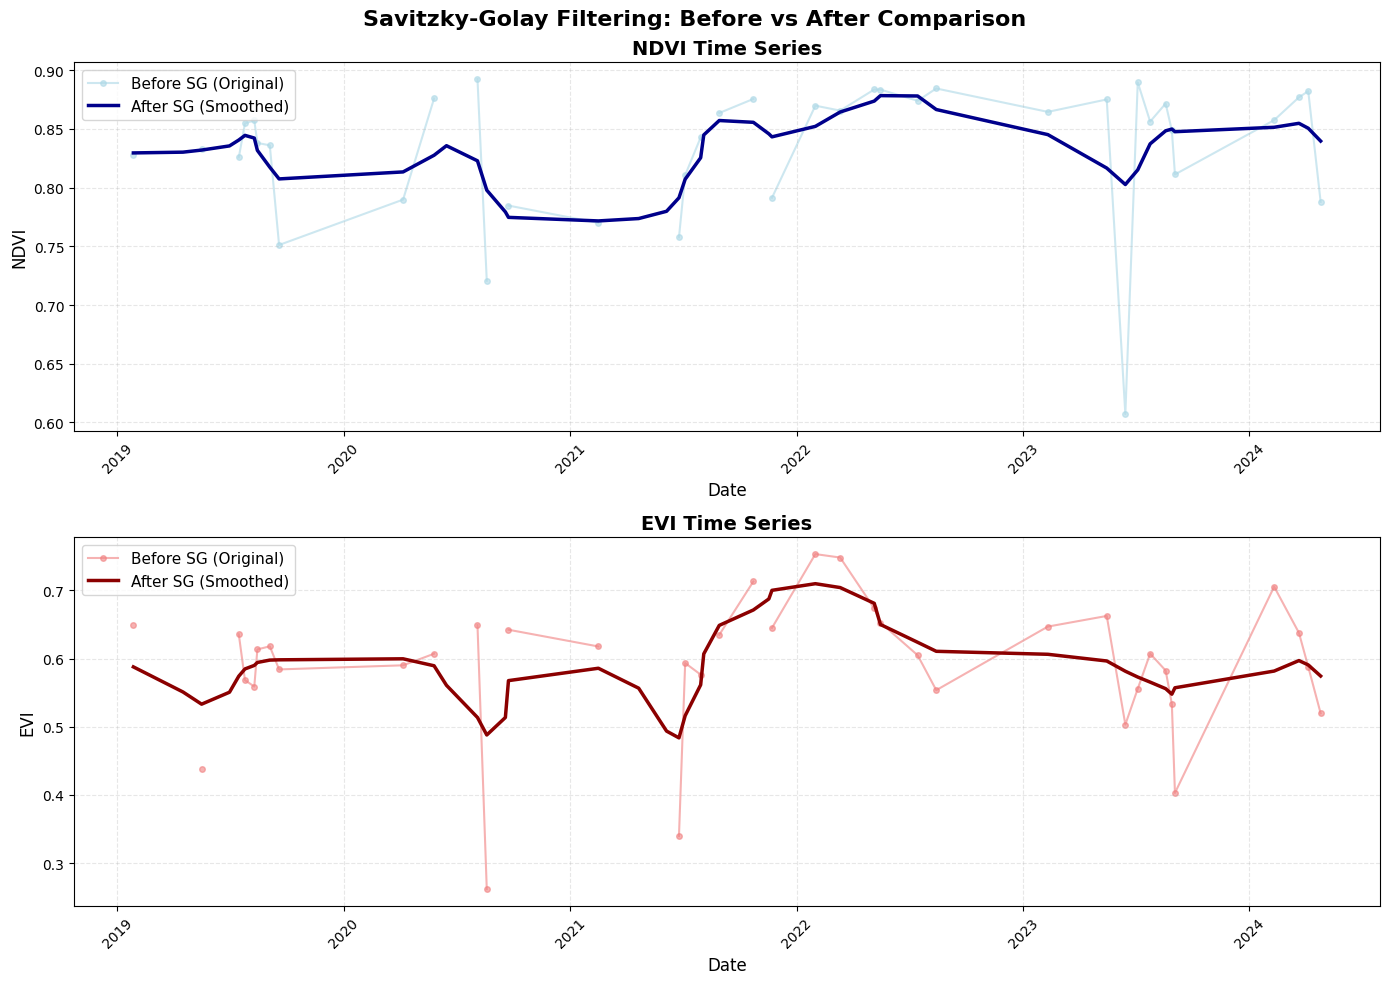


📊 Summary Statistics:
NDVI Statistics:
  Before SG - Mean: 0.8340, Std: 0.0578
  After SG  - Mean: 0.8311, Std: 0.0279
  Noise Reduction: 51.7%

EVI Statistics:
  Before SG - Mean: 0.5913, Std: 0.1000
  After SG  - Mean: 0.5873, Std: 0.0550
  Noise Reduction: 44.9%


In [82]:
# Create visualization comparing before vs after Savitzky-Golay filtering
import matplotlib.pyplot as plt

# Create figure with subplots for NDVI and EVI
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
fig.suptitle('Savitzky-Golay Filtering: Before vs After Comparison', fontsize=16, fontweight='bold')

# Plot NDVI
ax1 = axes[0]
if 'NDVI' in ts_before_df.columns and 'NDVI' in ts_after_df.columns:
    ax1.plot(ts_before_df['date'], ts_before_df['NDVI'], 
             'o-', color='lightblue', alpha=0.6, linewidth=1.5, markersize=4,
             label='Before SG (Original)', zorder=1)
    ax1.plot(ts_after_df['date'], ts_after_df['NDVI'], 
             '-', color='darkblue', linewidth=2.5,
             label='After SG (Smoothed)', zorder=2)

ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('NDVI', fontsize=12)
ax1.set_title('NDVI Time Series', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.tick_params(axis='x', rotation=45)

# Plot EVI
ax2 = axes[1]
if 'EVI' in ts_before_df.columns and 'EVI' in ts_after_df.columns:
    ax2.plot(ts_before_df['date'], ts_before_df['EVI'], 
             'o-', color='lightcoral', alpha=0.6, linewidth=1.5, markersize=4,
             label='Before SG (Original)', zorder=1)
    ax2.plot(ts_after_df['date'], ts_after_df['EVI'], 
             '-', color='darkred', linewidth=2.5,
             label='After SG (Smoothed)', zorder=2)

ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('EVI', fontsize=12)
ax2.set_title('EVI Time Series', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=11)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n📊 Summary Statistics:")
print("=" * 60)

if 'NDVI' in ts_before_df.columns and 'NDVI' in ts_after_df.columns:
    before_ndvi_mean = ts_before_df['NDVI'].mean()
    before_ndvi_std = ts_before_df['NDVI'].std()
    after_ndvi_mean = ts_after_df['NDVI'].mean()
    after_ndvi_std = ts_after_df['NDVI'].std()
    
    print("NDVI Statistics:")
    print(f"  Before SG - Mean: {before_ndvi_mean:.4f}, Std: {before_ndvi_std:.4f}")
    print(f"  After SG  - Mean: {after_ndvi_mean:.4f}, Std: {after_ndvi_std:.4f}")
    if before_ndvi_std > 0:
        noise_reduction_ndvi = (1 - after_ndvi_std/before_ndvi_std) * 100
        print(f"  Noise Reduction: {noise_reduction_ndvi:.1f}%")

if 'EVI' in ts_before_df.columns and 'EVI' in ts_after_df.columns:
    before_evi_mean = ts_before_df['EVI'].mean()
    before_evi_std = ts_before_df['EVI'].std()
    after_evi_mean = ts_after_df['EVI'].mean()
    after_evi_std = ts_after_df['EVI'].std()
    
    print("\nEVI Statistics:")
    print(f"  Before SG - Mean: {before_evi_mean:.4f}, Std: {before_evi_std:.4f}")
    print(f"  After SG  - Mean: {after_evi_mean:.4f}, Std: {after_evi_std:.4f}")
    if before_evi_std > 0:
        noise_reduction_evi = (1 - after_evi_std/before_evi_std) * 100
        print(f"  Noise Reduction: {noise_reduction_evi:.1f}%")


In [77]:
collection_with_sg.first().bandNames().getInfo()

['blue',
 'green',
 'red',
 'redE1',
 'redE2',
 'redE3',
 'nir',
 'redE4',
 'swir1',
 'swir2',
 'EVI',
 'SAVI',
 'cloudM',
 'BI',
 'MTVI2',
 'pseudo_fcd_pct',
 'SI',
 'VARI',
 'ndwi',
 'GNDVI',
 'NDVI',
 'msavi2',
 'BSI']

## Savitzky-Golay Filtering and Monthly Aggregation

This section implements the time series processing workflow:

**Workflow Order:**
1. **Savitzky-Golay Filtering** (first) - Smooths time series at original temporal resolution
2. **Monthly Aggregation with Interpolation** (second) - Aggregates to monthly and fills gaps

**Why this order?**
- SG filtering works better with more data points (higher temporal resolution)
- Reduces noise before aggregation (better signal-to-noise ratio)
- Standard practice in time series analysis
- Interpolation fills remaining gaps during monthly aggregation


## Monthly Time Series Aggregation (Step 2)

**After** Savitzky-Golay filtering, aggregate the smoothed time series to monthly intervals.
This creates regular monthly time steps with interpolation for missing months.


In [ ]:
# Aggregate filtered collection to monthly time series with interpolation
# This creates regular monthly composites from the SG-filtered data and interpolates missing months

def aggregate_to_monthly(collection, reducer=ee.Reducer.median(), interpolate_missing=True):
    """
    Aggregate ImageCollection to monthly composites with interpolation for missing months.
    
    Groups images by year-month and applies a reducer (median by default).
    Interpolates missing months using linear interpolation from neighboring months.
    This creates regular monthly time steps for time series analysis.
    
    Parameters:
    -----------
    collection : ee.ImageCollection
        Input image collection (after SG filtering)
    reducer : ee.Reducer
        Reducer to use for aggregation (default: median)
        Options: ee.Reducer.median(), ee.Reducer.mean(), ee.Reducer.max(), etc.
    interpolate_missing : bool
        If True, interpolate missing months using linear interpolation (default: True)
    
    Returns:
    --------
    ee.ImageCollection : Monthly aggregated collection with all months filled
    """
    from datetime import datetime, timedelta
    
    # Get list of images
    collection_list = collection.toList(collection.size())
    n_images = collection.size().getInfo()
    
    # Extract unique year-month combinations
    def get_year_month(img):
        """Extract year-month from image date."""
        date = ee.Image(img).date()
        year = date.get('year')
        month = date.get('month')
        # Create a composite key: year * 100 + month (e.g., 202401 for Jan 2024)
        year_month = year.multiply(100).add(month)
        return ee.Image(img).set('year_month', year_month).set('year', year).set('month', month)
    
    # Add year-month to all images
    collection_with_ym = collection.map(get_year_month)
    
    # Get unique year-month values (months that have data)
    def extract_ym(img):
        return ee.Feature(None, {'year_month': ee.Image(img).get('year_month')})
    
    unique_ym_features = collection_with_ym.map(extract_ym).distinct(['year_month'])
    unique_ym_list = sorted(unique_ym_features.aggregate_array('year_month').getInfo())
    
    print(f"   Found {len(unique_ym_list)} months with data")
    
    # Get date range to determine all expected months
    first_date = ee.Image(collection.first()).date().getInfo()
    last_date = ee.Image(collection.sort('system:time_start', False).first()).date().getInfo()
    
    # Generate list of all months in the range
    def generate_all_months(start_date, end_date):
        """Generate list of all year-month combinations in the date range."""
        all_months = []
        current = datetime(start_date.year, start_date.month, 1)
        end = datetime(end_date.year, end_date.month, 1)
        
        while current <= end:
            ym = current.year * 100 + current.month
            all_months.append(ym)
            # Move to next month
            if current.month == 12:
                current = current.replace(year=current.year + 1, month=1)
            else:
                current = current.replace(month=current.month + 1)
        
        return all_months
    
    all_months = generate_all_months(first_date, last_date)
    missing_months = [ym for ym in all_months if ym not in unique_ym_list]
    
    print(f"   Total months in range: {len(all_months)}")
    if missing_months:
        print(f"   Missing months to interpolate: {len(missing_months)}")
    
    # Group images by year-month and aggregate
    monthly_dict = {}  # Store by year_month for easy lookup
    
    for ym in unique_ym_list:
        # Filter collection for this year-month
        ym_collection = collection_with_ym.filter(
            ee.Filter.eq('year_month', ym)
        )
        
        # Aggregate using reducer (median by default)
        monthly_composite = ym_collection.reduce(reducer)
        
        # Add date information
        year = ym // 100
        month = ym % 100
        # Create date for the first day of the month
        month_date = ee.Date.fromYMD(year, month, 1)
        
        # Set system:time_start to the first of the month
        monthly_composite = monthly_composite.set('system:time_start', month_date.millis())
        
        # Add interpolation flag band (0 = real data, not interpolated)
        # This allows filtering out interpolated data for ground truth
        interpolation_flag = ee.Image.constant(0).rename('is_interpolated')
        monthly_composite = monthly_composite.addBands(interpolation_flag)
        
        monthly_dict[ym] = monthly_composite
    
    # Interpolate missing months
    if interpolate_missing and missing_months:
        print(f"   Interpolating {len(missing_months)} missing months...")
        
        for ym in missing_months:
            year = ym // 100
            month = ym % 100
            
            # Find previous and next available months
            prev_ym = None
            next_ym = None
            
            # Search backwards
            for check_ym in sorted(unique_ym_list, reverse=True):
                if check_ym < ym:
                    prev_ym = check_ym
                    break
            
            # Search forwards
            for check_ym in sorted(unique_ym_list):
                if check_ym > ym:
                    next_ym = check_ym
                    break
            
            # Interpolate based on available neighbors
            if prev_ym and next_ym:
                # Linear interpolation between prev and next
                prev_img = monthly_dict[prev_ym]
                next_img = monthly_dict[next_ym]
                
                # Calculate time weights
                prev_year = prev_ym // 100
                prev_month = prev_ym % 100
                next_year = next_ym // 100
                next_month = next_ym % 100
                
                # Calculate months difference
                prev_months_since_start = (prev_year - first_date.year) * 12 + (prev_month - first_date.month)
                next_months_since_start = (next_year - first_date.year) * 12 + (next_month - first_date.month)
                current_months_since_start = (year - first_date.year) * 12 + (month - first_date.month)
                
                # Calculate interpolation weight
                total_dist = next_months_since_start - prev_months_since_start
                dist_from_prev = current_months_since_start - prev_months_since_start
                weight = dist_from_prev / total_dist if total_dist > 0 else 0.5
                
                # Linear interpolation: result = prev + (next - prev) * weight
                interpolated = prev_img.add(
                    next_img.subtract(prev_img).multiply(weight)
                )
                
            elif prev_ym:
                # Only previous month available - use forward fill
                interpolated = monthly_dict[prev_ym]
                
            elif next_ym:
                # Only next month available - use backward fill
                interpolated = monthly_dict[next_ym]
            
            else:
                # No neighbors available - skip this month
                continue
            
            # Set date for interpolated image
            month_date = ee.Date.fromYMD(year, month, 1)
            interpolated = interpolated.set('system:time_start', month_date.millis())
            
            # Add interpolation flag band (1 = interpolated, 0 = real data)
            # This allows filtering out interpolated data for ground truth
            interpolation_flag = ee.Image.constant(1).rename('is_interpolated')
            interpolated = interpolated.addBands(interpolation_flag)
            
            monthly_dict[ym] = interpolated
    
    # Convert dictionary to list, sorted by year_month
    monthly_images = [monthly_dict[ym] for ym in sorted(monthly_dict.keys())]
    
    # Create monthly collection
    monthly_collection = ee.ImageCollection(monthly_images)
    
    # Sort by date
    monthly_collection = monthly_collection.sort('system:time_start')
    
    return monthly_collection

# ============================================================================
# STEP 2: Monthly Aggregation with Interpolation (after SG filtering)
# ============================================================================
# After Savitzky-Golay filtering, aggregate to monthly and interpolate gaps
print(f"\n📅 STEP 2: Aggregating to monthly time series with interpolation...")
print(f"   Input: collection_with_sg (Savitzky-Golay filtered)")
print(f"   Interpolation: Enabled (fills missing months)")
print(f"   Order: SG filter first → Monthly aggregation second (optimal workflow)")

# Use median reducer for monthly aggregation (robust to outliers)
# interpolate_missing=True will fill gaps using linear interpolation
collection_monthly = aggregate_to_monthly(
    collection_with_sg,
    reducer=ee.Reducer.median(),  # Can change to ee.Reducer.mean() if preferred
    interpolate_missing=True  # Interpolate missing months
)

print(f"✅ Monthly aggregation with interpolation complete!")

# Check results
print(f"\n📊 Monthly collection info:")
try:
    n_months = collection_monthly.size().getInfo()
    print(f"   Number of monthly composites: {n_months}")
    
    # Get date range
    first_date = ee.Image(collection_monthly.first()).date().format('YYYY-MM-dd').getInfo()
    last_date = ee.Image(collection_monthly.sort('system:time_start', False).first()).date().format('YYYY-MM-dd').getInfo()
    print(f"   Date range: {first_date} to {last_date}")
    
    # Check bands
    monthly_bands = collection_monthly.first().bandNames().getInfo()
    print(f"   Bands: {len(monthly_bands)}")
    print(f"   Spectral indices: {[b for b in monthly_bands if b in ['NDVI', 'EVI', 'GNDVI', 'SAVI']]}")
except Exception as e:
    print(f"   ⚠️ Could not get collection info: {e}")

print(f"\n💾 Monthly time series collection stored as: collection_monthly")
print(f"\n📌 Interpolation Flag Band: 'is_interpolated'")
print(f"   - 0 = Real data (from actual images)")
print(f"   - 1 = Interpolated data (filled from neighbors)")
print(f"   - Use this band to filter out interpolated data for ground truth validation")


In [ ]:
# Example: Filter out interpolated data for ground truth validation

# Get collection with only real (non-interpolated) data
collection_monthly_real_only = collection_monthly.map(
    lambda img: img.updateMask(img.select('is_interpolated').eq(0))
)

# Or select only real data images
collection_monthly_groundtruth = collection_monthly.filter(
    ee.Filter.eq('is_interpolated', 0)  # Note: This filters by image property, not band value
)

# Better approach: Create a collection where interpolated pixels are masked
# This preserves all images but masks interpolated pixels
collection_monthly_for_validation = collection_monthly.map(
    lambda img: img.updateMask(img.select('is_interpolated').eq(0))
)

print("✅ Filtered collections created:")
print(f"   - collection_monthly_real_only: Only real data pixels (interpolated masked)")
print(f"   - collection_monthly_for_validation: Use this for ground truth validation")

# Check statistics
try:
    n_total = collection_monthly.size().getInfo()
    
    # Count interpolated vs real months
    def check_interpolation_status(img):
        is_interp = img.select('is_interpolated').reduceRegion(
            ee.Reducer.mode(),
            geometry=aoi_ee,
            scale=1000,  # Coarse scale for quick check
            bestEffort=True
        ).get('is_interpolated')
        return ee.Feature(None, {'is_interp': is_interp})
    
    # Sample a few images to check
    sample_img = collection_monthly.first()
    interp_sample = sample_img.select('is_interpolated').reduceRegion(
        ee.Reducer.mode(),
        geometry=aoi_ee,
        scale=1000,
        bestEffort=True
    ).getInfo()
    
    print(f"\n📊 Interpolation Statistics:")
    print(f"   Total monthly composites: {n_total}")
    print(f"   Sample interpolation flag value: {interp_sample.get('is_interpolated', 'N/A')}")
    print(f"   (0 = real data, 1 = interpolated)")
    
except Exception as e:
    print(f"   ⚠️ Could not get statistics: {e}")

print(f"\n💡 Usage Tip:")
print(f"   When using data for ground truth validation or training:")
print(f"   - Filter: img.select('is_interpolated').eq(0) to get only real data")
print(f"   - Or use: collection_monthly_for_validation (already filtered)")


## Comparison: getTimeSeriesByRegion() vs Our SG Filter + Monthly Aggregation

**Key Difference:**

`getTimeSeriesByRegion()` from eemont-osi:
- **Purpose**: Time series EXTRACTION (not filtering)
- **What it does**: Extracts aggregated values (mean/median) from ImageCollection over geometry
- **Output**: `ee.FeatureCollection` (tabular data - dates, band values, reducers)
- **No Savitzky-Golay filtering**: It does NOT include SG filtering or smoothing
- **Use case**: Get time series values for specific points/regions for analysis

**Our Implementation (SG Filter + Monthly Aggregation):**
- **Purpose**: Time series FILTERING and REGULARIZATION
- **What it does**: 
  1. Smooths ImageCollection with Savitzky-Golay filter (reduces noise)
  2. Aggregates to monthly intervals
  3. Interpolates missing months
- **Output**: `ee.ImageCollection` (spatially preserved, monthly cadence)
- **Includes SG filtering**: Yes, plus monthly aggregation and interpolation
- **Use case**: Create clean, regular monthly ImageCollection for further processing

**Can they be combined?**
Yes! You can:
1. Apply our SG filter + monthly aggregation → `collection_monthly`
2. Then extract time series from the filtered collection:
   ```python
   ts = collection_monthly.getTimeSeriesByRegion(
       reducer=ee.Reducer.mean(),
       geometry=aoi_ee,
       bands=['NDVI', 'EVI'],
       scale=100
   )
   ```


In [ ]:
# Example: Using eemont-osi getTimeSeriesByRegion() with our filtered monthly collection
# This extracts tabular time series from the SG-filtered monthly ImageCollection

print("📊 Example: Extracting time series from monthly collection using eemont-osi...")
print("   This combines our SG filtering with eemont's extraction method")

# Extract time series from the monthly filtered collection
# This gives you tabular data (pandas-ready) from the smoothed monthly composites
try:
    ts_monthly = collection_monthly.getTimeSeriesByRegion(
        reducer=[ee.Reducer.mean(), ee.Reducer.median()],
        geometry=aoi_ee,
        bands=['NDVI', 'EVI'],
        scale=100,
        dateColumn='date',
        dateFormat='ISO'
    )
    
    print(f"✅ Time series extraction successful!")
    print(f"   Output: ee.FeatureCollection (can convert to pandas)")
    print(f"   Reducers: mean, median")
    print(f"   Bands: NDVI, EVI")
    print(f"   Note: This extracts from the SG-filtered monthly collection")
    print(f"\n   To convert to pandas:")
    print(f"   import geemap")
    print(f"   ts_df = geemap.ee_to_pandas(ts_monthly)")
    
    # Store reference
    print(f"\n💾 Time series stored as: ts_monthly")
    
except Exception as e:
    print(f"⚠️ Could not extract time series (may need to run previous cells first): {e}")
    print(f"   This is expected if collection_monthly is not yet computed")


In [ ]:
### SAVITSKY GOLAY INTERPOLATION AND SMOOTHING
import eemont
collection_with_fcd


## Convert Earth Engine ImageCollection to xarray Dataset using xee

**What is xee?**
- `xee` (xarray-earth-engine) is a bridge library that connects Google Earth Engine with xarray
- It allows you to work with GEE ImageCollections as if they were xarray Datasets
- This enables time-series analysis, easy indexing, and integration with other xarray-based tools

**Why use xee?**
- Familiar xarray interface for Earth Engine data
- Lazy loading: only loads data when needed
- Time dimension: automatically handles time-series
- Easy integration with dask for parallel processing
- Works seamlessly with STAC workflows

In [ ]:
# Step 5: Convert ImageCollection to xarray Dataset using xee
# Now using UTM CRS with meter scale - they match!
import xee
import xarray as xr

print("🔄 Converting Earth Engine ImageCollection to xarray Dataset...")
print(f"   CRS: {utm_crs} (UTM, meters)")
print(f"   Scale: {pixel_scale}m")
print("   This may take a moment as xee accesses the data from Earth Engine...")

# Reproject aoi_ee to UTM first (for region parameter)
# Use aoi_ee_utm already created in cell 11 (UTM geometry)

from shapely.geometry import box

# bbox = box(*aoi_gpd_utm.total_bounds)
# Get UTM bounds from GeoDataFrame and validate
aoi_gpd_utm = aoi_gpd.to_crs(f'EPSG:{utm_epsg}')
bounds_utm = aoi_gpd_utm.total_bounds  # [minx, miny, maxx, maxy]

# Validate bounds are not NaN
if np.any(np.isnan(bounds_utm)):
    raise ValueError(f"Bounds contain NaN values: {bounds_utm}")

xmin, ymin, xmax, ymax = bounds_utm
print(f"UTM Bounds: xmin={xmin:.2f}, ymin={ymin:.2f}, xmax={xmax:.2f}, ymax={ymax:.2f}")
print(f"UTM Bounds span: {(xmax-xmin):.2f}m x {(ymax-ymin):.2f}m")

# Create rectangle geometry in UTM CRS
# rectangle = ee.Geometry.Rectangle(xmin, ymin, xmax, ymax)

ic = collection_with_fcd

# Method 2: Use transformed geometry directly (more reliable)
# Create UTM geometry from aoi_ee
aoi_ee_utm_geom = aoi_ee.geometry().transform(
    f'EPSG:{utm_epsg}',
    maxError=1
)

ds = xr.open_dataset(
    ic,
    engine='ee',
    crs=utm_crs,
    scale=pixel_scale,
    geometry=aoi_ee_utm_geom # significanly faster to clip with geometry
)
print("✅ Successfully created dataset using transformed geometry")

if 'X' in ds.dims and 'Y' in ds.dims:
    print("Renaming dimensions from X,Y to x,y")
    ds = ds.rename({'X': 'x', 'Y': 'y'})

print(f"\n📦 Dataset created: {type(ds)}")
print(f"   CRS: {utm_crs} (UTM, meters)")
print(f"   Scale: {pixel_scale}m")
print(f"   Dimensions: {dict(ds.dims)}")
print(f"   Data variables: {list(ds.data_vars.keys())}")
print(f"   Coordinates: {list(ds.coords.keys())}")


In [ ]:
import pandas as pd

# image id mapping
ids = (ee.ImageCollection(ic)
       .toList(ic.size())
       .map(lambda img: ee.Image(img).id()))
ids = ids.getInfo() 
# ids

ds = ds.assign_coords(image_id=("time", ids))

# Convert only if needed
if not pd.api.types.is_datetime64_any_dtype(ds["time"].dtype):
    ds = ds.assign_coords(time=pd.to_datetime(ds["time"].values))

# Sort only if not monotonic
if not ds.indexes["time"].is_monotonic_increasing:
    print('sorting time its not monotonic')
    ds = ds.sortby("time")

# Ensure image_id is a coord aligned to time
if "image_id" not in ds.coords:
    raise ValueError("image_id coordinate not found. Assign it with ds = ds.assign_coords(image_id=(\"time\", ids)).")

# Choose your time window - example usage
start, end = "2024-01-01", "2024-12-31"
sel = ds.sel(time=slice(start, end))

# Extract mapping time -> image_id (1D, cheap)
times = pd.to_datetime(sel["time"].values)
ids = sel["image_id"].values

print(f"Selected scenes between {start} and {end}: {len(times)}")
for t, i in zip(times, ids):
    print(f"{t.isoformat()} -> {i}")


In [ ]:
ds

In [ ]:
new_date_start_end

In [ ]:
xmin, ymin, xmax, ymax

In [ ]:
# ds

In [ ]:
# box(*aoi_gpd_utm.total_bounds)

In [ ]:
# Step 6: Explore the xarray Dataset structure
# Let's examine what we have

print("🔍 Exploring xarray Dataset Structure:")
print("=" * 60)
print("\n1. Dataset Overview:")
print(ds)

print("\n2. Dataset Dimensions:")
for dim_name, dim_size in ds.dims.items():
    print(f"   {dim_name}: {dim_size} values")

print("\n3. Data Variables (Bands):")
for var_name in ds.data_vars:
    var = ds[var_name]
    print(f"   {var_name}:")
    print(f"      Shape: {var.shape}")
    print(f"      Dtype: {var.dtype}")
    print(f"      Attributes: {var.attrs if hasattr(var, 'attrs') else 'None'}")

print("\n4. Coordinates:")
for coord_name in ds.coords:
    coord = ds.coords[coord_name]
    print(f"   {coord_name}: {coord.shape} - {coord.values[:3] if len(coord.values) > 0 else 'No values'}...")

print("\n5. Dataset Attributes:")
print(f"   {ds.attrs if hasattr(ds, 'attrs') else 'No attributes'}")


In [ ]:
# Step 7: Access and visualize sample data
# Note: xee uses lazy loading - data is computed when you access it

print("📊 Sample Data Access (first time slice):")
print("=" * 60)

# Get the first band name
if len(ds.data_vars) > 0:
    first_band = list(ds.data_vars.keys())[0]
    print(f"\n1. Accessing first band: '{first_band}'")
    print(f"   Type: {type(ds[first_band])}")
    
    # Get first time slice (lazy - not computed yet)
    first_time_slice = ds[first_band].isel(time=0)
    print(f"   First time slice shape: {first_time_slice.shape}")
    print(f"   First time slice dtype: {first_time_slice.dtype}")
    
    print("\n2. Time information:")
    if 'time' in ds.coords:
        time_coords = ds.coords['time']
        print(f"   Number of time steps: {len(time_coords)}")
        print(f"   Time range: {time_coords.values[0]} to {time_coords.values[-1]}")
        
    print("\n3. Spatial information:")
    if 'x' in ds.coords and 'y' in ds.coords:
        x_coords = ds.coords['x']
        y_coords = ds.coords['y']
        print(f"   X range: {x_coords.values[0]:.4f} to {x_coords.values[-1]:.4f}")
        print(f"   Y range: {y_coords.values[0]:.4f} to {y_coords.values[-1]:.4f}")
        print(f"   Pixel size X: {(x_coords.values[-1] - x_coords.values[0]) / len(x_coords):.4f}")
        print(f"   Pixel size Y: {(y_coords.values[-1] - y_coords.values[0]) / len(y_coords):.4f}")
    
else:
    print("⚠️ No data variables found in dataset!")


In [ ]:
config_timeseries = {}

# Processing parameters
# valid_pixel_threshold = config_timeseries.get('valid_pixel_threshold',70)  # Keep scenes with >90% valid pixels
# smoothing_window = config_timeseries.get('smoothing_window',90)       # Savitzky-Golay window length
# smoothing_polyorder = config_timeseries.get('smoothing_polyorder',2)     # Savitzky-Golay polynomial order
# outlier_window = config_timeseries.get('outlier_window',14)         # Window for outlier detection
# outlier_threshold = config_timeseries.get('outlier_threshold',0.1)    # Outlier detection threshold (10%)

valid_pixel_threshold = 70

# Monthly time-series parameter overrides
# Use small, odd window; polyorder < window; outlier window in months
smoothing_window = 7            # suitable for monthly cadence
smoothing_polyorder = 2         # keep small to preserve shape
outlier_window = 3              # ~3 months for outlier detection
outlier_threshold = 0.15        # 15% threshold for spikes/drops
print("Monthly params set:", smoothing_window, smoothing_polyorder, outlier_window, outlier_threshold)


In [ ]:
# SIMPLIFIED EFFICIENT ZARR SAVING
# Focus: Proper parallelism, simple and reliable
# Removed complex auto-detection that might cause issues

import os
import xarray as xr
import zarr
from numcodecs import Blosc
import time

def save_dataset_efficient_zarr(
    ds, 
    zarr_path, 
    chunk_sizes=None,
    compression='lz4',
    compression_level=1,
    overwrite=True,
    consolidated=True
):
    """
    Simplified zarr saving - focuses on reliable parallelism.
    
    Parameters:
    -----------
    ds : xarray.Dataset
        Dataset to save (can be lazy dask arrays or in-memory)
    zarr_path : str
        Path to zarr store (directory)
    chunk_sizes : dict, optional
        Chunk sizes per dimension (e.g., {'time': 20, 'x': 256, 'y': 256})
    compression : str
        'lz4' (fastest), 'blosc', 'zstd', or None (no compression)
    compression_level : int
        Compression level (1=fastest, 9=best compression)
    overwrite : bool
        Overwrite existing zarr store
    consolidated : bool
        Create consolidated metadata
        
    Returns:
    --------
    zarr_path : str
    """
    start_time = time.time()
    
    # Ensure directory exists
    zarr_dir = os.path.dirname(zarr_path) if os.path.dirname(zarr_path) else '.'
    if zarr_dir and not os.path.exists(zarr_dir):
        os.makedirs(zarr_dir, exist_ok=True)
    
    # Handle overwrite
    if os.path.exists(zarr_path):
        if not overwrite:
            raise FileExistsError(
                f"Zarr store already exists: {zarr_path}\n"
                f"Set overwrite=True to replace it."
            )
        import shutil
        print(f"🗑️  Removing existing zarr store: {zarr_path}")
        shutil.rmtree(zarr_path)
    
    # Default chunk sizes
    if chunk_sizes is None:
        chunk_sizes = {}
        dims = ds.dims
        if 'time' in dims:
            chunk_sizes['time'] = min(20, dims['time'])
        if 'x' in dims and 'y' in dims:
            chunk_sizes['x'] = min(256, dims['x'])
            chunk_sizes['y'] = min(256, dims['y'])
        for dim in dims:
            if dim not in chunk_sizes:
                chunk_sizes[dim] = min(100, dims[dim])
    
    print(f"📦 Saving to zarr: {zarr_path}")
    print(f"   Dimensions: {dict(ds.dims)}")
    print(f"   Chunks: {chunk_sizes}")
    print(f"   Compression: {compression} (level {compression_level})")
    
    # Prepare compression
    if compression == 'lz4':
        compressor = Blosc(cname='lz4', clevel=compression_level, shuffle=Blosc.SHUFFLE, blocksize=0)
        encoding = {var: {'compressor': compressor} for var in ds.data_vars}
    elif compression == 'blosc':
        compressor = Blosc(cname='lz4', clevel=compression_level, shuffle=Blosc.SHUFFLE, blocksize=0)
        encoding = {var: {'compressor': compressor} for var in ds.data_vars}
    elif compression == 'zstd':
        compressor = Blosc(cname='zstd', clevel=compression_level, shuffle=Blosc.SHUFFLE, blocksize=0)
        encoding = {var: {'compressor': compressor} for var in ds.data_vars}
    elif compression is None:
        encoding = {}
    else:
        encoding = compression
    
    # SIMPLIFIED: Just chunk and save - let xarray/dask handle parallelism
    # Don't try to detect or pre-compute - trust xarray's to_zarr
    ds_chunked = ds.chunk(chunk_sizes)
    
    print("💾 Writing to zarr (with automatic parallelism)...")
    
    # Simple approach: let xarray handle compute automatically
    # to_zarr with compute=True handles lazy arrays efficiently in parallel
    try:
        from dask.diagnostics import ProgressBar
        with ProgressBar():
            ds_chunked.to_zarr(
                zarr_path,
                mode='w',
                encoding=encoding,
                consolidated=consolidated,
                compute=True  # Let dask compute chunks in parallel during write
            )
    except ImportError:
        # No progress bar, but still works
        ds_chunked.to_zarr(
            zarr_path,
            mode='w',
            encoding=encoding,
            consolidated=consolidated,
            compute=True
        )
    
    elapsed = time.time() - start_time
    
    # Check size
    if os.path.exists(zarr_path):
        total_size = 0
        for dirpath, dirnames, filenames in os.walk(zarr_path):
            for f in filenames:
                fp = os.path.join(dirpath, f)
                total_size += os.path.getsize(fp)
        size_mb = total_size / (1024 * 1024)
        size_gb = size_mb / 1024
        size_str = f"{size_gb:.2f} GB" if size_gb >= 1 else f"{size_mb:.2f} MB"
        
        write_speed = total_size / elapsed / (1024 * 1024)  # MB/s
        print(f"✅ Dataset saved successfully!")
        print(f"   Store size: {size_str}")
        print(f"   Time: {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)")
        print(f"   Write speed: {write_speed:.1f} MB/s")
        print(f"   Path: {zarr_path}")
    else:
        print(f"⚠️  Warning: zarr store not found after saving")
    
    return zarr_path


def load_dataset_zarr(zarr_path, consolidated=True):
    """Load a dataset from zarr store."""
    if not os.path.exists(zarr_path):
        raise FileNotFoundError(f"Zarr store not found: {zarr_path}")
    
    print(f"📂 Loading dataset from zarr: {zarr_path}")
    ds = xr.open_zarr(zarr_path, consolidated=consolidated)
    print(f"✅ Dataset loaded: {dict(ds.dims)}")
    return ds


print("✅ Simplified zarr saving functions loaded!")
print("\nKey simplifications:")
print("  - No complex auto-detection")
print("  - Always uses compute=True (let dask handle parallelism)")
print("  - Simple, reliable, focuses on parallelism")
print("  - Works with both lazy and in-memory arrays")


In [ ]:
type(ds)

In [ ]:
print("use GEE")

# --- Step 1: Compute valid pixel percentage per scene ---
# Let Earth Engine compute the mean of valid pixels (server-side)
valid_pixels = (ds["cloudM"] == 1).mean(("y", "x")) * 100

# --- Step 2: Bring down only small summary stats ---
# This triggers small, fast fetches (not full rasters)
min_val = float(valid_pixels.min().values)
max_val = float(valid_pixels.max().values)

# Compute valid mask and count (still efficient)
valid_mask = valid_pixels > valid_pixel_threshold
n_valid = int((valid_mask).sum().values)
n_total = int(len(valid_pixels.time))

print(f"Valid pixel percentages: min={min_val:.1f}%, max={max_val:.1f}%")
print(f"Scenes with >{valid_pixel_threshold}% valid pixels: {n_valid}/{n_total}")

# --- Step 3: Filter dataset ---
# This step remains server-side (GEE will only load the scenes you need)
ds = ds.sel(time=valid_mask, drop=True)
print(f"After valid pixel filtering: {ds.dims}")

# --- Step 4: Cloud masking (already done in GEE) ---
# No need to apply ds.where(ds.cloudM == 1)
print("Applied cloud masking")


In [ ]:
print(ds)

In [ ]:
ds

In [ ]:
# Inspect time coordinate and list timestamps in 2024
import pandas as pd

# Ensure we have a datetime index/array from ds.time
_time_values = pd.to_datetime(ds["time"].values)
_time_index = pd.DatetimeIndex(_time_values)

print(f"Total scenes: {_time_index.size}")
print(f"Time span: {_time_index.min().date()} -> {_time_index.max().date()}")

# Filter to 2024 only (time info only, no further filtering yet)
_times_2024 = _time_index[_time_index.year == 2024]
print(f"Scenes in 2024: {len(_times_2024)}")

# Display the 2024 timestamps (ISO format)
for ts in _times_2024:
    print(ts.isoformat())


In [ ]:
## example selection
# If cloudM is 0/1
ds_example = ds.sel(time="2024-02-10")

ds_example

In [ ]:
ds

In [ ]:
import numpy as np
unique_vals = np.unique(ds['cloudM'].values)
print(f"Unique values: {unique_vals}")
print(f"Has 0: {0 in unique_vals}, Has 1: {1 in unique_vals}")

In [ ]:
print("🔍 Checking cloudM values in ds_example (optimized server-side)...")
print("=" * 60)

if 'cloudM' not in ds_example.data_vars:
    print("❌ ERROR: 'cloudM' not found in dataset.")
    print(f"Available variables: {list(ds_example.data_vars.keys())}")
else:
    cloudM = ds_example['cloudM']

    # --- Method 1: Compute unique values using xarray/xee's reduction (lazy if Dask/GEE-backed)
    print("\n📊 Unique values (computed lazily if possible):")
    try:
        unique_vals = cloudM.astype("float32").chunk({"x": 512, "y": 512}).reduce(np.nanmin, dim=None)
        min_val = unique_vals.compute()  # triggers computation, minimal data pulled
        max_val = cloudM.reduce(np.nanmax, dim=None).compute()
        print(f"   Value range: min={min_val}, max={max_val}")
    except Exception as e:
        print("⚠️ Could not compute unique values lazily:", e)

    # --- Method 2: Compute fraction of valid pixels per time step (still on server if xee-backed)
    print("\n📈 Fraction of clear pixels per time slice:")
    if "time" in cloudM.dims:
        valid_fraction = (cloudM == 1).mean(dim=("x", "y"))
        cloudy_fraction = (cloudM == 0).mean(dim=("x", "y"))

        # These remain deferred operations until .compute() or .values is called
        print("   Computing summary (this runs on GEE if xee-backed)...")
        summary = xr.Dataset({
            "clear_fraction": valid_fraction,
            "cloudy_fraction": cloudy_fraction
        }).compute()

        for t_idx, t_val in enumerate(summary.time.values[:3]):  # first 3 timesteps
            cf = float(summary.clear_fraction.isel(time=t_idx).values * 100)
            cl = float(summary.cloudy_fraction.isel(time=t_idx).values * 100)
            print(f"   Time {t_idx} ({t_val}): clear={cf:.2f}%, cloud={cl:.2f}%")

    # --- Method 3: Summary statistics (still lazy)
    print("\n📊 Summary:")
    print(f"   Dtype: {cloudM.dtype}")
    print(f"   Shape: {cloudM.shape}")
    print(f"   Dims: {list(cloudM.dims)}")
    print(f"   Lazy computation: {'Yes' if hasattr(cloudM.data, 'compute') else 'No'}")

print("\n" + "=" * 60)
print("💡 Interpretation:")
print("   - All operations above stay on GEE unless `.values` or `.compute()` is called.")
print("   - `.values` or `.compute()` explicitly fetches data to client.")
print("   - Keep operations vectorized (e.g. `.mean()`, `.reduce()`) to use Earth Engine’s computation graph.")


In [ ]:
# # QUICK CHECK - One-liner version
# import numpy as np

# # Quick check for unique values
# unique_vals = np.unique(ds_example['cloudM'].values)
# print(f"Unique values in cloudM: {unique_vals}")
# print(f"Has 0: {0 in unique_vals}, Has 1: {1 in unique_vals}")

# # Quick counts
# cloudm = ds_example['cloudM'].values
# print(f"Count of 0: {np.sum(cloudm == 0):,}")
# print(f"Count of 1: {np.sum(cloudm == 1):,}")
# print(f"Count of NaN: {np.sum(np.isnan(cloudm)):,}")

print("Checking cloudM values lazily (server-side)...")

cloudM = ds_example["cloudM"]

# Fraction of clear and cloudy pixels (server-side computation)
clear_fraction = (cloudM == 1).mean(("x", "y"))
cloud_fraction = (cloudM == 0).mean(("x", "y"))

# Trigger minimal computation only
summary = cloudM.reduce(np.nanmin, dim=None).compute(), cloudM.reduce(np.nanmax, dim=None).compute()
print(f"Min, Max values: {summary}")

print("\nAverage clear/cloud ratio per timestep:")
if "time" in cloudM.dims:
    frac = xr.Dataset({
        "clear": clear_fraction,
        "cloud": cloud_fraction
    }).compute()  # still small – only one value per time slice
    print(frac)


In [ ]:
print("⚙️ Using GEE server-side masking via Xee")

# Ensure we're working on GEE-backed data
assert hasattr(ds_example['swir1'].data, "_ee_object"), "This dataset is not Xee-backed!"

# --- Step 1: Define the lazy mask operation (server-side) ---
# When using xee, operations like .where() or arithmetic are translated into
# Earth Engine expressions, not computed locally.
result_lazy = ds_example['swir1'].where(ds_example['cloudM'] == 0)

# --- Step 2: Confirm it's still a GEE-backed XeeArray ---
print(f"✅ Type: {type(result_lazy.data)} (should be xee.xarray.XeeArray)")
print("📡 Still server-side; nothing has been downloaded yet.")

# --- Step 3: Optional — get metadata only (safe server-side) ---
print("🧩 Metadata:")
print(f"  Shape: {result_lazy.sizes}")
print(f"  Dims: {result_lazy.dims}")
print(f"  Data type: {result_lazy.dtype}")

# --- Step 4: Do NOT call .values or .compute() here ---
# Those would trigger a full download.
# Instead, perform further chained operations — mean(), reduce(), etc. —
# and only call .values at the end for small summaries if needed.


In [ ]:
print(type(ds['swir1'].data))


In [ ]:
# result_lazy.compute()

In [ ]:
# Accessing data where cloudM == 1 (valid pixels)
# cloudM == 1 means no cloud, but some values may be NaN outside AOI boundary
result_valid = ds_example['swir1'].where(ds_example['cloudM'] == 1).data
print(f"Type: {type(result_valid)} - Still lazy (chunked)")
print("Note: NaN values can occur due to:")
print("  - Outside AOI geometry boundary")
print("  - Missing data in source")
print("  - Processing artifacts")


In [ ]:
result_valid

In [ ]:
# result_valid.compute()

In [ ]:
# QUICK CHECK - One-liner methods

# Quick check if has values:
result = result_valid.compute()
has_values = np.any(~np.isnan(result))
print(f"Has values: {has_values}")

# Count valid values:
if has_values:
    valid_pct = 100 * np.sum(~np.isnan(result)) / result.size
    print(f"Valid values: {np.sum(~np.isnan(result)):,} / {result.size:,} ({valid_pct:.1f}%)")
    
# Get min/max of valid values:
if has_values:
    print(f"Value range: [{np.nanmin(result):.4f}, {np.nanmax(result):.4f}]")


In [ ]:
ds

In [ ]:
ds.dims

In [ ]:
ds_x = ds.x.values
ds_x[0]

In [ ]:
ds_y = ds.y.values
ds_y[0]

In [ ]:
ds_time_list = ds.time.values
ds_time_list


In [ ]:
ds_time_list[0]

In [ ]:
ds_example_one_point_value = ds_example.isel(x=46, y=0, time=0)
ds_example_one_point_value['swir2'].values

In [ ]:
ds_example_one_point_value.image_id.values

In [ ]:
# do timeseries selection per month - for its best availability here, as we can see that probably not possible for daily
print(ds)


In [ ]:
start_date = ds.time.values[0]
end_date = ds.time.values[-1]

print(f"Start date: {start_date}")
print(f"End date: {end_date}")

# resampling, for using later in smoothing
resampling_freq = 'MS'  # Monthly resampling
output_freq = 'MS'  

In [ ]:
ds_time_list

In [ ]:
ds

In [ ]:
# check if we can get the data and masking the duplicates, this is requires for STAC, but for GEE i think we dont have problem, but we can see the differences later in dims
mask = ~pd.Series(ds.time.values).duplicated().values
ds_removed_duplicates = ds.isel(time=mask, drop=True)
print(f"After removing duplicates: {ds_removed_duplicates.dims}")

# check the time range
# ds_removed_duplicates.time.values

In [ ]:
# ds_time_list


In [ ]:
list(ds.data_vars)

In [ ]:
# !pip install scipy

In [ ]:
import os

# interpolation
resampled_t  = pd.date_range(ds.time.min().values, ds.time.max().values, freq=resampling_freq)
# resampled_t

# check the time range
# ds_removed_duplicates.time.values

# # resampled_t
bands_to_interp =  [
#  'cloudM',
 'NDVI',
 'ndwi',
 'msavi2',
 'MTVI2',
 'VARI',
 'BSI',
 'BI',
 'SI',
 'pseudo_fcd_pct']

# band_data_list = []
# for band in list(bands_to_interp):
#     print('start with band ', band )
#     band_data = ds[band].interp(time=resampled_t)
#     band_data_list.append(band_data)

# improvement
# Ensure monotonic, unique time
ds = ds.sortby('time')
ds = ds.sel(time=~ds.indexes['time'].duplicated())

zarr_path = 'data/ds_resampled.zarr'

if not os.path.exists(zarr_path):
    # Direct linear interpolation onto target grid (requires SciPy)
    ds_resampled = ds[bands_to_interp].interp(time=resampled_t, method='linear')
    ds_resampled
else:
    print('we will load the zarr file in the next cell')


In [ ]:
# !pip install zarr

In [ ]:
### CAUSE IT TAKES TIME LETS SAVE THE DATASET TO ZARR - one time only, later we can just load the zarr file
import os
import importlib

# Reload xarray plugins to ensure zarr engine is available (in case zarr was installed after xarray import)
import xarray as xr
importlib.reload(xr.backends.plugins)

# if path not exists, then save the dataset to zarr
if not os.path.exists(zarr_path):
    # Save to zarr (keep using in-memory version)
    save_dataset_efficient_zarr(ds_resampled, zarr_path,
    chunk_sizes={'time': 20, 'x': 256, 'y': 256},  # Optimized for time-series processing
        compression='lz4',  # Fastest compression option
        compression_level=1,  # Level 1 = fastest (use 3-5 for better compression if speed not critical)
        overwrite=True,
        consolidated=True
    )
else:
    ds_resampled = load_dataset_zarr(zarr_path)
    
ds_resampled

In [ ]:
from scipy.signal import savgol_filter

def remove_drops_and_spikes_1d(ser, window, threshold_percent):
    """
    Process a 1D time series to remove drops and spikes.
    
    Parameters:
    -----------
    ser : 1D numpy array
        Time series data
    window : int
        Size of the rolling window for outlier detection
    threshold_percent : float
        Relative threshold for flagging outliers (e.g., 0.1 for 10%)
    
    Returns:
    --------
    cleaned : 1D numpy array
        Time series with outliers replaced by interpolated values
    """
    eps = 1e-6  # Avoid division by zero
    s = pd.Series(ser)
    median = s.rolling(window=window, center=True, min_periods=1).median().values
    
    spikes = ((ser - median) / (np.abs(median) + eps)) > threshold_percent
    drops = ((median - ser) / (np.abs(median) + eps)) > threshold_percent
    outliers = spikes | drops
    
    # Replace outliers with NaN
    ser_no_outliers = ser.copy()
    ser_no_outliers[outliers] = np.nan
    
    # Interpolate over NaN values using linear interpolation
    x = np.arange(len(ser))
    valid = ~np.isnan(ser_no_outliers)
    if valid.sum() < 2:
        cleaned = ser_no_outliers  # Not enough valid points to interpolate
    else:
        cleaned = np.interp(x, x[valid], ser_no_outliers[valid])
        
    return cleaned

In [ ]:
ds

In [ ]:
ds_resampled

In [ ]:
from tqdm.auto import tqdm
from dask.diagnostics import ProgressBar

# ds_resampled
def clean_and_smooth_1d(ts, outlier_window, outlier_threshold, polyorder, window_length):
    if np.all(np.isnan(ts)):
        return ts
    cleaned = remove_drops_and_spikes_1d(ts, window=outlier_window, threshold_percent=outlier_threshold)
    return savgol_filter(cleaned, polyorder=polyorder, window_length=window_length, mode="interp")

## OPTIMIZED: Process bands separately to reduce memory footprint
# This approach processes each band independently, reducing memory per chunk from ~1.8GB to ~180MB
# Much faster and more memory-efficient than processing all bands at once

import dask.array as da

smoothed_bands = {}
total_bands = len(bands_to_interp)

print(f"🔄 Processing {total_bands} bands separately (more memory-efficient)...")
print(f"   This approach uses ~10x less memory per operation")

for i, band_name in enumerate(tqdm(bands_to_interp, desc="Bands", unit="band"), 1):
    print(f"   [{i}/{total_bands}] Processing {band_name}...")
    
    # Process one band at a time
    band_arr = ds_resampled[band_name]
    
    # Chunking: time must be single chunk for core dimension, spatial dimensions chunked
    # Smaller spatial chunks = lower memory per chunk, better parallelism
    band_arr = band_arr.chunk({"time": -1, "y": 256, "x": 256})
    
    # Apply smoothing function
    smoothed_band = xr.apply_ufunc(
        clean_and_smooth_1d,
        band_arr,
        kwargs=dict(
            outlier_window=outlier_window,
            outlier_threshold=outlier_threshold,
            polyorder=smoothing_polyorder,
            window_length=smoothing_window,
        ),
        input_core_dims=[["time"]],
        output_core_dims=[["time"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[band_arr.dtype],
    )

    with ProgressBar():
        smoothed_bands[band_name] = smoothed_band.compute()
    print(f"       ✅ {band_name} complete")

# Combine into dataset
smoothed = xr.Dataset(smoothed_bands)

print(f"\n✅ All {total_bands} bands processed and combined!")
print("✅ Smoothing computation complete!")

In [ ]:
arr

In [ ]:
smoothed

In [ ]:
from matplotlib import pyplot as plt

def plot_time_series(ds, x_idx, y_idx, title="Time Series"):
    """
    Plot time series for a specific pixel.
    
    Parameters:
    -----------
    ds : xarray.Dataset
        Dataset containing time series data
    x_idx, y_idx : int
        Pixel coordinates
    title : str
        Plot title
    """
    plt.figure(figsize=(15, 5))
    
    if 'NDVI' in ds.data_vars:
        ds.NDVI.isel(x=x_idx, y=y_idx).plot(label='NDVI', alpha=0.7)
    if 'EVI' in ds.data_vars:
        ds.EVI.isel(x=x_idx, y=y_idx).plot(label='EVI', alpha=0.7)
        
    plt.title(f"{title} - x={x_idx}, y={y_idx}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
# Resample to monthly (aggregate to monthly averages)
# This actually creates monthly data by averaging all observations within each month
band_clean = smoothed.resample(time='MS').mean()  # 'MS' = Month Start

# OPTIMIZED: Compute after resample since smoothed is already computed
# This makes the next resample operation fast
print("🔄 Computing monthly resampled data...")
band_clean = band_clean.compute()
print("✅ Monthly resampling complete!")

# Alternatively, you can use other aggregation functions:
# band_clean = smoothed.resample(time='MS').median().compute()  # monthly median
# band_clean = smoothed.resample(time='MS').max().compute()     # monthly maximum

band_clean

In [ ]:
resampling_freq = resampling_freq
monthly_time = pd.date_range(start_date, end_date, freq=resampling_freq)
monthly_time


In [ ]:
band_clean = band_clean.reindex(time=monthly_time)
band_clean

In [ ]:
ds_processed = band_clean

# Resample to final output frequency
ds_processed = ds_processed.resample(time=output_freq).mean()
print(f"Final dataset shape: {ds_processed.dims}")
print(f"Time range: {ds_processed.time.min().values} to {ds_processed.time.max().values}")

# Add plot dimension
ds_processed = ds_processed.expand_dims(plot=['aoi'])
print(f"With plot dimension: {ds_processed.dims}")

In [ ]:
ds_processed

In [ ]:
# Extract a single value - should be FAST now since data is already computed!
# After optimizations, ds_processed should be in memory (not lazy)
ndvi_value = ds_processed.isel(x=30, y=30, time=30, plot=0)['NDVI'].values
print(f"NDVI value: {ndvi_value}")

# Alternative: Use .item() for scalar values
# ndvi_value = ds_processed.isel(x=30, y=30, time=30, plot=0)['NDVI'].item()

ndvi_value 

In [ ]:
import random

layer = 'aoi'

# Plot a random time series
if ds_processed.NDVI.size > 0:
    # Find a pixel with valid data
    valid_pixels = np.where(~ds_processed.NDVI.isnull().all(dim='time'))
    if len(valid_pixels[0]) > 0:
        idx = random.randint(0, len(valid_pixels[0]) - 1) # plot (draw) the random pixel in the dataset
        y_idx, x_idx = valid_pixels[0][idx], valid_pixels[1][idx]
        
        plot_time_series(ds_processed, x_idx, y_idx, f"Processed {layer}")
    else:
        print("No valid pixels found for plotting")
else:
    print("No data to plot")


In [ ]:
print("N time steps:", ds_resampled.sizes["time"])
print("requested window:", smoothing_window, "polyorder:", smoothing_polyorder)